In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycountry
!pip install --upgrade pip
!pip install git+https://github.com/MCFreddie777/language-check.git
!pip install pycontractions
!pip install contractions
!pip install nltk
!python -m nltk.downloader punkt
!nltk.download('stopwords')
!python -m nltk.downloader stopwords
!pip install datasets
!pip install accelerate -U
!pip install transformers
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Cloning https://github.com/MCFreddie777/language-check.git to /tmp/pip-req-build-fym1naac
  Running command git clone --filter=blob:none --quiet https://github.com/MCFreddie777/language-check.git /tmp/pip-req-build-fym1naac
  Resolved https://github.com/MCFreddie777/language-check.git to commit 337493f25b5a49af0a09b0e264f306eccefaff8f
  Preparing metadata (setup.py) ... done
  Created wheel for language-check: filename=language_check-1.1-py3-none-any.whl size=90190985 sha256=ce3b0cb4a85b0dfe340fefa716a8719dd50a5dcd00837214646b6c013b06228b
  Stored in directory: /tmp/pip-ephem-wheel-cache-jn90gwi0/wheels/d3/8b/b0/8f065f9ad75fb34b9be70a3cc1e2a24fec7a72d0c823c562d2
Successfully built languag

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import pycountry
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import contractions
import heapq
import matplotlib.patches as mpatches
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import accelerate
import transformers
from imblearn.over_sampling import RandomOverSampler
# Libraries for deep learning using with tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import pipeline
from sklearn.utils import resample

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FYP - SA - James & Stephan/DataSet/file.csv")
df_copy = df

In [ ]:
print(df.shape)
df.head()

(219294, 3)


,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [ ]:
num_features = df.shape[1]
print("Number of features:", num_features)

Number of features: 3


In [ ]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [ ]:
duplicates_exist = df.duplicated(subset=['id']).any()

if duplicates_exist:
    print("Duplicates exist in the 'id_column'.")
else:
    print("All IDs are unique.")

All IDs are unique.


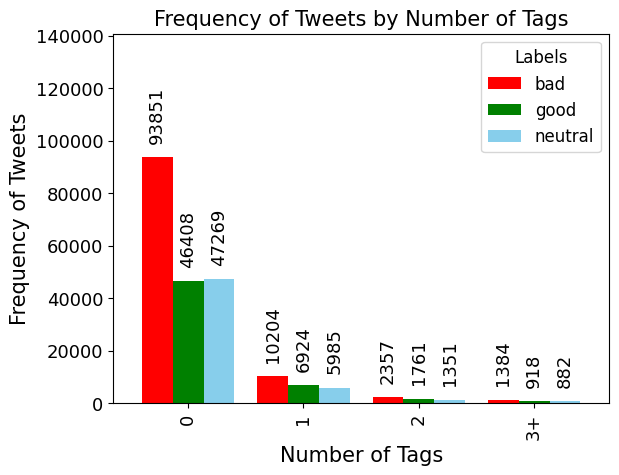

In [ ]:
#tags count
def extract_tags(text):
    tags = re.findall(r'@(\w+)', text)
    return len(tags)

df['tags_count'] = df['tweets'].apply(extract_tags)

df['tags_category'] = df['tags_count'].apply(lambda x: str(x) if x <= 2 else '3+')

grouped = df.groupby(['tags_category', 'labels']).size().unstack(fill_value=0)

colors = {'good': 'green', 'bad': 'red', 'neutral': 'skyblue'}
ax = grouped.plot(kind='bar', stacked=False, color=[colors[col] for col in grouped.columns], width=0.8)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', rotation=90,fontsize=13)

max_height = grouped.values.max()
ax.set_ylim(0, max_height * 1.5)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Number of Tags',fontsize=15)
plt.ylabel('Frequency of Tweets',fontsize=15)
plt.title('Frequency of Tweets by Number of Tags',fontsize=15)
legend = plt.legend(title='Labels',fontsize=12)
plt.setp(legend.get_title(),fontsize='large')
plt.show()

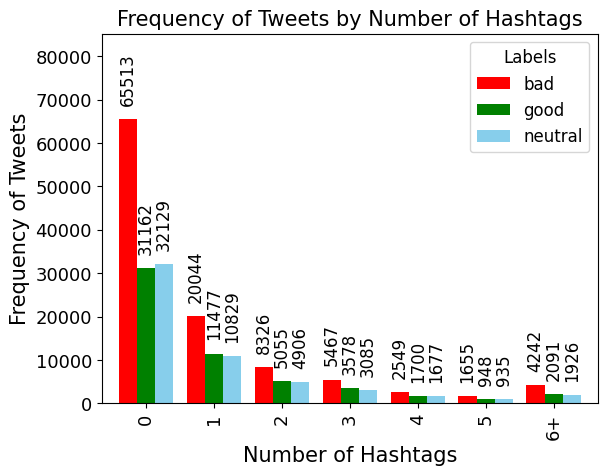

In [ ]:
#hashtag count
def count_hashtags(tweet):
    return tweet.count('#')
df['hashtags_count'] = df['tweets'].apply(count_hashtags)

df['hashtags_category'] = df['hashtags_count'].apply(lambda x: str(x) if x <= 5 else '6+')

grouped = df.groupby(['hashtags_category', 'labels']).size().unstack(fill_value=0)

colors = {'good': 'green', 'bad': 'red', 'neutral': 'skyblue'}
ax = grouped.plot(kind='bar', stacked=False, color=[colors[col] for col in grouped.columns], width=0.8)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', rotation=90,fontsize=12)

max_height = grouped.values.max()
ax.set_ylim(0, max_height * 1.3)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Number of Hashtags',fontsize=15)
plt.ylabel('Frequency of Tweets',fontsize=15)
plt.title('Frequency of Tweets by Number of Hashtags',fontsize=15)
legend = plt.legend(title='Labels',fontsize=12)
plt.setp(legend.get_title(),fontsize='large')
plt.show()

# **Data cleaning**

In [ ]:
df = df.drop_duplicates(subset=['tweets'])

In [ ]:
# Remove links from tweets
removed_links=0
def remove_links(tweet):
    global removed_links
    # Regex pattern to match links (http/https/www)
    link_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # Replace links with an empty string
    cleaned_tweet = re.sub(link_pattern, '', tweet)
    if removed_links < 5:
        print("original tweet: " + tweet)
        print("cleaned tweet : " + cleaned_tweet)
        removed_links += 1
    return cleaned_tweet

df['tweets'] = df['tweets'].apply(remove_links)

original tweet: ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI
cleaned tweet : ChatGPT: Optimizing Language Models for Dialogue  @OpenAI
original tweet: Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr
cleaned tweet : Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. 
original tweet: ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\n\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34
cleaned tweet : ChatGPT: Optimizing Language Models for Dialogue  #AI #MachineLearning #DataScience #ArtificialIntelligence\n\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer 
original tweet: THRILLED

<ipython-input-12-8aad5ce0b2d8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets'] = df['tweets'].apply(remove_links)


In [ ]:
#remove mentions
removed_mentions_count = 0
def remove_mentions(tweet):
    global removed_mentions_count
    mention_pattern = r'@[^\s]+'
    cleaned_tweet = re.sub(mention_pattern, '', tweet)
    if (removed_mentions_count<5 and tweet!=cleaned_tweet):
      print("tweet: "+ tweet)
      print("cleaned:" + cleaned_tweet)
      removed_mentions_count+=1
    return cleaned_tweet
df['tweets'] = df['tweets'].apply(remove_mentions)

tweet: ChatGPT: Optimizing Language Models for Dialogue  @OpenAI
cleaned:ChatGPT: Optimizing Language Models for Dialogue  
tweet: As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now 👇  
cleaned:As of 2 minutes ago,  released their new ChatGPT. \n\nAnd you can use it right now 👇  
tweet: As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now \n \n🤯  
cleaned:As of 2 minutes ago,  released their new ChatGPT. \n\nAnd you can use it right now \n \n🤯  
tweet: GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I AM TOO BUSY 
cleaned:GOD DAMN IT  STOP ANNOUNCING THINGS I AM TOO BUSY 
tweet: #ai Models are set to become the search engines of the future, ATM they still struggle with veracity… here is #chatgpt by @OpenAI based on #GPT3. #seo\n\n
cleaned:#ai Models are set to become the search engines of the future, ATM they still struggle with veracity… here is #chatgpt by  based on #GPT3. #seo\n\n


<ipython-input-13-25abe5760dc9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets'] = df['tweets'].apply(remove_mentions)


In [ ]:
#Remove emails
removed_emails_count = 0
def remove_emails(tweet):
    global removed_emails_count
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    cleaned_tweet = re.sub(email_pattern, '', tweet)
    if removed_emails_count < 5 and tweet != cleaned_tweet:
        print("tweet: " + tweet)
        print("cleaned: " + cleaned_tweet)
        removed_emails_count += 1
    return cleaned_tweet

df['tweets'] = df['tweets'].apply(remove_emails)

<ipython-input-14-ca4cbf7d2a17>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets'] = df['tweets'].apply(remove_emails)


In [ ]:
#Lowercasing + Sentence Capital (tagged with SC)
def modify_tweet(tweet):
    if tweet.isupper():
        return tweet.lower() + " SC"
    else:
        return tweet.lower()

df['tweets'] = df['tweets'].apply(modify_tweet)

<ipython-input-15-3993b350ce12>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets'] = df['tweets'].apply(modify_tweet)


In [ ]:
#Remove ChatGpt-only tweets
df = df[~((df['tweets'] == "chatgpt") & (df['tweets'].str.split().str.len() == 1))]

In [ ]:
removed_special_characters = 0

def remove_special_characters(tweet):
    global removed_special_characters
    cleaned_tweet = tweet.replace("\\n", "").replace("\\t", "").replace("\\r", "")
    if cleaned_tweet != tweet and removed_special_characters<6:
      print("original tweet: "+ tweet)
      print("adjusted tweet: "+ cleaned_tweet)
      removed_special_characters+=1
    return cleaned_tweet

df['tweets'] = df['tweets'].apply(remove_special_characters)

original tweet: chatgpt: optimizing language models for dialogue  #ai #machinelearning #datascience #artificialintelligence\n\ntrending ai/ml article identified &amp; digested via granola; a machine-driven rss bot by ramsey elbasheer 
adjusted tweet: chatgpt: optimizing language models for dialogue  #ai #machinelearning #datascience #artificialintelligencetrending ai/ml article identified &amp; digested via granola; a machine-driven rss bot by ramsey elbasheer 
original tweet: as of 2 minutes ago,  released their new chatgpt. \n\nand you can use it right now 👇  
adjusted tweet: as of 2 minutes ago,  released their new chatgpt. and you can use it right now 👇  
original tweet: as of 2 minutes ago,  released their new chatgpt. \n\nand you can use it right now \n \n🤯  
adjusted tweet: as of 2 minutes ago,  released their new chatgpt. and you can use it right now  🤯  
original tweet: #0penal just deployed a thing i've been helping build the last couple of months, it's a chatbot based on gpt

In [ ]:
#Tag the tweets with countries with CNT
country_names = [country.name.lower() for country in list(pycountry.countries)]
country_count = 0
def replace_countries(tweet):
    global countries_list
    global country_count
    tweet_changed = False
    words = tweet.split()
    for i, word in enumerate(words):
        if word in country_names:
            words[i] = 'cnt'
            tweet_changed= True

    if tweet_changed and country_count<10:
      print("tweet before: " + tweet)
      print("tweet after:  " + ' '.join(words))
      country_count+=1
    return ' '.join(words)

df['tweets'] = df['tweets'].apply(replace_countries)

tweet before: #umatbersaturezimbisu#umatbersaturezimbisutatum tunisia kross poland chatgpthmm!the lion sleeps tonight - the tokens 👇 
tweet after:  #umatbersaturezimbisu#umatbersaturezimbisutatum cnt kross cnt chatgpthmm!the lion sleeps tonight - the tokens 👇
tweet before: #umatbersaturezimbisu#umatbersaturezimbisutatum tunisia kross poland chatgptas i walk along i wondera what went wrong whit our lovea love that was so strongand as i still walk oni think of the things we've donetogether while our hearts were youngrunaway - del shannon👇 
tweet after:  #umatbersaturezimbisu#umatbersaturezimbisutatum cnt kross cnt chatgptas i walk along i wondera what went wrong whit our lovea love that was so strongand as i still walk oni think of the things we've donetogether while our hearts were youngrunaway - del shannon👇
tweet before: #umatbersaturezimbisu#umatbersaturezimbisutatum tunisia kross poland chatgptok, understood 
tweet after:  #umatbersaturezimbisu#umatbersaturezimbisutatum cnt kross cn

In [ ]:
#Fix contractions
contractions_changed = 0
def fix_contraction(tweet):
    global contractions_changed
    cleaned_tweet = contractions.fix(tweet)
    if (contractions_changed <5 and tweet!=cleaned_tweet):
      print("tweet: "+ tweet)
      print("cleaned:" + cleaned_tweet)
      contractions_changed +=1
    return cleaned_tweet
df['tweets'] = df['tweets'].apply(fix_contraction)

tweet: #0penal just deployed a thing i've been helping build the last couple of months, it's a chatbot based on gpt 3. i'm really excited to share this vl
cleaned:#0penal just deployed a thing i have been helping build the last couple of months, it is a chatbot based on gpt 3. i am really excited to share this vl
tweet: it's very clear chatgpt was trained to avoid prescriptive answers, instead "counseling" the human at reaching their own conclusion.present it with the trolly problem, and it helps you find a framework to think through it.ask to be more direct, and it openly refuses.
cleaned:it is very clear chatgpt was trained to avoid prescriptive answers, instead "counseling" the human at reaching their own conclusion.present it with the trolly problem, and it helps you find a framework to think through it.ask to be more direct, and it openly refuses.
tweet: the chatgpt research preview is out today at and we're excited to get your feedback -- especially to help understand and context

In [ ]:
# Removed stopwords except negation stopwords
stop_words = set(stopwords.words('english'))
negation_stopwords = set(['no', 'not', 'never', 'nor','none','neither','never','nobody','nothing','without','against','but','neither'])
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words or word.lower() in negation_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

df['tweets'] = df['tweets'].apply(remove_stopwords)

In [ ]:
#Fix chatgpt
chat_gpt_changed = 0
def globalize_chatgpt(tweet):
    global chat_gpt_changed
    gpt_pattern = r'chat\s*[-_]?gpt'
    cleaned_tweet = re.sub(gpt_pattern, 'chatgpt', tweet)
    if (chat_gpt_changed<5 and tweet!=cleaned_tweet):
      print("tweet: "+ tweet)
      print("cleaned:" + cleaned_tweet)
      chat_gpt_changed+=1
    return cleaned_tweet
df['tweets'] = df['tweets'].apply(globalize_chatgpt)

tweet: chatgpt needs smart friend? chat gpt day long!
cleaned:chatgpt needs smart friend? chatgpt day long!
tweet: asked chat-gpt variation coupon collector's problem, exception arithmetic error (leading incorrect final answer), nailed much logic!#openai #chatgpt
cleaned:asked chatgpt variation coupon collector's problem, exception arithmetic error (leading incorrect final answer), nailed much logic!#openai #chatgpt
tweet: responses seen chat-gpt mind-blowing! waiting day chat damn thing :) #chatgpt
cleaned:responses seen chatgpt mind-blowing! waiting day chat damn thing :) #chatgpt
tweet: first impressions openai chat gpt could hope for! - real analysis tutor session 🧵 #openai #chatgpt
cleaned:first impressions openai chatgpt could hope for! - real analysis tutor session 🧵 #openai #chatgpt
tweet: spent 40 minutes using chat-gpt shit's insane man. #chatgpt
cleaned:spent 40 minutes using chatgpt shit's insane man. #chatgpt


In [ ]:
string.punctuation.replace("?", "").replace("!", "").replace("#", "")

'"$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

In [ ]:
# Remove punctuations except ... , ! , ?
def remove_punctuation(text):
    punctuation_to_remove = string.punctuation.replace("?", "").replace("!", "").replace("#", "")
    cleaned_text = text.replace('&', 'and')
    cleaned_text = cleaned_text.translate(str.maketrans('', '', punctuation_to_remove))
    return cleaned_text

df['tweets'] = df['tweets'].apply(remove_punctuation)

In [ ]:
#remove white spaces and null
removed_white_spaces = 0
def remove_white_spaces(tweet):
    global removed_white_spaces
    cleaned_tweet = re.sub(r'\s+', ' ', tweet)
    cleaned_tweet = cleaned_tweet.strip()
    if (removed_white_spaces<20 and tweet!=cleaned_tweet):
      print("tweet: "+ tweet)
      print("cleaned:" + cleaned_tweet)
      removed_white_spaces+=1
    return cleaned_tweet
df['tweets'] = df['tweets'].apply(remove_white_spaces)
df = df[df['tweets'].str.strip().astype(bool)]

tweet: chatgpt research preview today excited get feedback  especially help understand contextualize model risks see details thread chatgpt feedback contest too!
cleaned:chatgpt research preview today excited get feedback especially help understand contextualize model risks see details thread chatgpt feedback contest too!
tweet: in! #chatgpt  research early stage gpt3 optimised chat remembers conversation
cleaned:in! #chatgpt research early stage gpt3 optimised chat remembers conversation
tweet: chatgpt trained humancentric way  excited play clarification uncertainty
cleaned:chatgpt trained humancentric way excited play clarification uncertainty
tweet: chatgpt first look  thing incredible education roleplaying more! wow! #chatgpt #openai #ai #artificialintelligence #gpt3
cleaned:chatgpt first look thing incredible education roleplaying more! wow! #chatgpt #openai #ai #artificialintelligence #gpt3
tweet: well quite impressed chatgpt far  looks like safety transparency taken account
clea

In [ ]:
#Remove ChatGpt-only tweets
df = df[~((df['tweets'] == "chatgpt") & (df['tweets'].str.split().str.len() == 1))]

In [ ]:
df['tweets'] = df['tweets'].apply(remove_white_spaces)
df = df[df['tweets'].str.strip().astype(bool)]

In [ ]:
def tokenize_tweet(tweet):
    return word_tokenize(tweet)
df['tokenized_tweet'] = df['tweets'].apply(tokenize_tweet)

In [ ]:
df.head(10)

,id,tweets,labels,tags_count,tags_category,hashtags_count,hashtags_category,tokenized_tweet
0,0,chatgpt optimizing language models dialogue,neutral,1,1,0,0,"[chatgpt, optimizing, language, models, dialogue]"
1,1,try talking chatgpt new ai system optimized di...,good,0,0,0,0,"[try, talking, chatgpt, new, ai, system, optim..."
2,2,chatgpt optimizing language models dialogue #a...,neutral,0,0,4,4,"[chatgpt, optimizing, language, models, dialog..."
3,3,thrilled share chatgpt new model optimized dia...,good,0,0,0,0,"[thrilled, share, chatgpt, new, model, optimiz..."
4,4,2 minutes ago released new chatgpt use right 👇,bad,1,1,0,0,"[2, minutes, ago, released, new, chatgpt, use,..."
5,5,launched chatgpt new ai system optimized dialo...,good,0,0,0,0,"[launched, chatgpt, new, ai, system, optimized..."
6,6,2 minutes ago released new chatgpt use right 🤯,bad,1,1,0,0,"[2, minutes, ago, released, new, chatgpt, use,..."
7,7,chatgpt coming strong refusing help stalk some...,good,0,0,0,0,"[chatgpt, coming, strong, refusing, help, stal..."
8,8,#0penal deployed thing helping build last coup...,good,0,0,1,1,"[#, 0penal, deployed, thing, helping, build, l..."
9,9,research preview newest model chatgptwere tryi...,neutral,0,0,0,0,"[research, preview, newest, model, chatgptwere..."


# **EDA**

In [ ]:
print(df.shape)
df.head()

(216996, 8)


,id,tweets,labels,tags_count,tags_category,hashtags_count,hashtags_category,tokenized_tweet
0,0,chatgpt optimizing language models dialogue,neutral,1,1,0,0,"[chatgpt, optimizing, language, models, dialogue]"
1,1,try talking chatgpt new ai system optimized di...,good,0,0,0,0,"[try, talking, chatgpt, new, ai, system, optim..."
2,2,chatgpt optimizing language models dialogue #a...,neutral,0,0,4,4,"[chatgpt, optimizing, language, models, dialog..."
3,3,thrilled share chatgpt new model optimized dia...,good,0,0,0,0,"[thrilled, share, chatgpt, new, model, optimiz..."
4,4,2 minutes ago released new chatgpt use right 👇,bad,1,1,0,0,"[2, minutes, ago, released, new, chatgpt, use,..."


In [ ]:
num_duplicates = df.duplicated(subset=['tweets']).sum()

print("Number of duplicate messages:", num_duplicates)

Number of duplicate messages: 20777


In [ ]:
duplicated_messages = df[df.duplicated(subset=['tweets'], keep=False)]

for message, group in duplicated_messages.groupby('tweets'):
    unique_emotions = group['labels'].unique()
    if len(unique_emotions) > 1:
      print(f"{message}", unique_emotions)

#chatgpt amazing ['good' 'bad']
2023 year openai’s chatgpt breaks free? ['good' 'bad']
ai bot chatgpt writes smart essays — academics worry? ['neutral' 'bad']
ai platforms like chatgpt easy use but also potentially dangerous ['good' 'neutral']
amazing#chatgpt ['bad' 'good']
asked ai bot chatgpt design strategy win independence ['bad' 'good']
asked chatgpt write bunch social media posts results astounding ['neutral' 'bad']
cannot stop playing chatgpt ['neutral' 'bad']
chatgpt ai tools help dyslexic worker send nearperfect emails ['neutral' 'good']
chatgpt care? ['neutral' 'bad']
chatgpt chatbot blowing people away writing skills expert explains impressive ['good' 'bad']
chatgpt everything need know openais powerful potentially problematic chatbot ['bad' 'neutral']
chatgpt galactica progress trap ['neutral' 'bad']
chatgpt holds promise peril ['neutral' 'bad']
chatgpt interesting ['neutral' 'bad']
chatgpt know api security? ['bad' 'neutral']
chatgpt knows well ['neutral' 'bad']
chatgpt le

In [ ]:
def remove_duplicates_with_different_emotions(df):
  duplicated_messages = df[df.duplicated(subset=['tweets'], keep=False)]
  filtered_df = df[~df['tweets'].isin(duplicated_messages['tweets'])]
  return filtered_df

df = remove_duplicates_with_different_emotions(df)
df = df.drop_duplicates(subset=['tweets'])

In [ ]:
print(df.shape)

(190293, 8)


['red', 'green', 'skyblue']


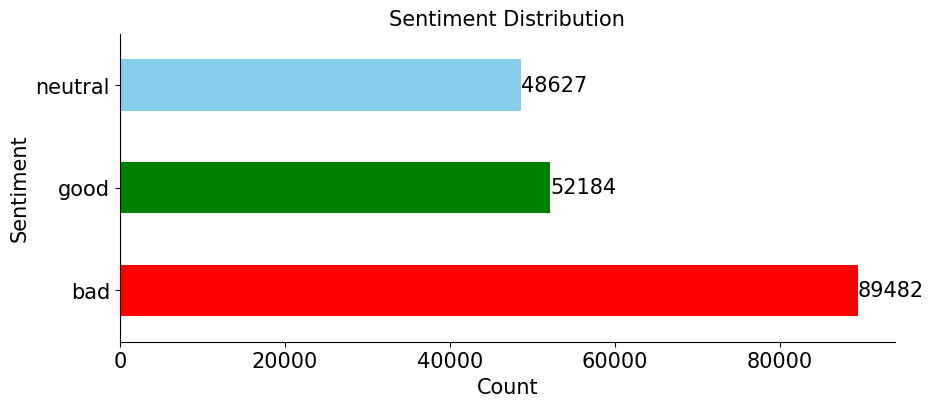

In [ ]:
# Sentiment distribution
colors = [ 'red', 'green','skyblue' ]
print(colors)
ax = df.groupby('labels').size().plot(kind='barh', color=colors, figsize=(10, 4))

for i, v in enumerate(df.groupby('labels').size()):
    ax.text(v + 3, i, str(v), ha='left', va='center', color='black', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Count', fontsize=15)
plt.ylabel('Sentiment', fontsize=15)
plt.title('Sentiment Distribution', fontsize=15)
plt. yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()

In [ ]:
df.isna().sum()

id                   0
tweets               0
labels               0
tags_count           0
tags_category        0
hashtags_count       0
hashtags_category    0
tokenized_tweet      0
dtype: int64

In [ ]:
#Wordclouds
def join_tweets(df, emotion):
    filtered_tweets = df[df['labels'] == emotion]['tweets']
    return ' '.join(filtered_tweets)
def create_word_cloud(emotion):
  # Define your stopwords
  custom_stopwords = set(STOPWORDS)
  custom_stopwords.update(["chatgpt", "OpenAI", "ai", "google","write", "new","chatbot", "asked", "use", "using"])

  word_cloud_bad = WordCloud(collocations=False, background_color='white',
                            width=2048, height=1080, stopwords=custom_stopwords).generate(join_tweets(df, emotion))

  plt.imshow(word_cloud_bad, interpolation='bilinear')
  plt.axis("off")
  plt.show()

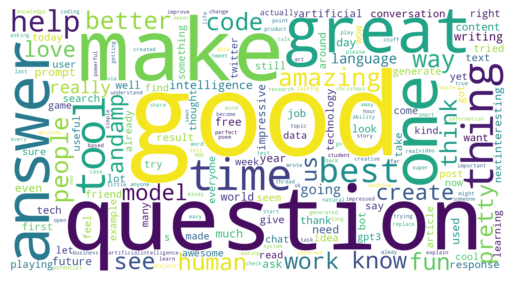

In [ ]:
create_word_cloud("good")

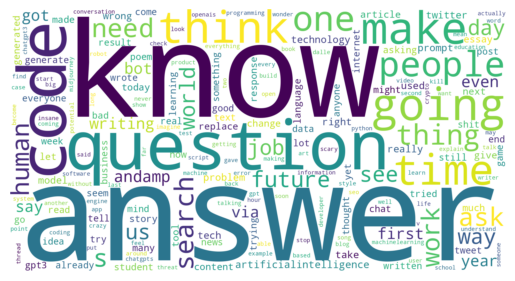

In [ ]:
create_word_cloud("bad")

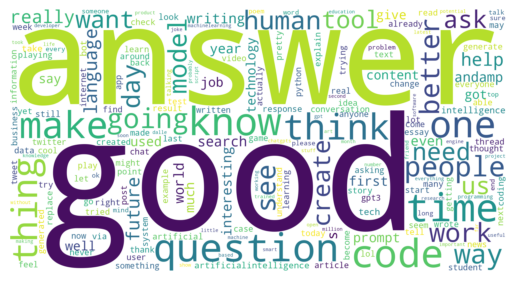

In [ ]:
create_word_cloud("neutral")

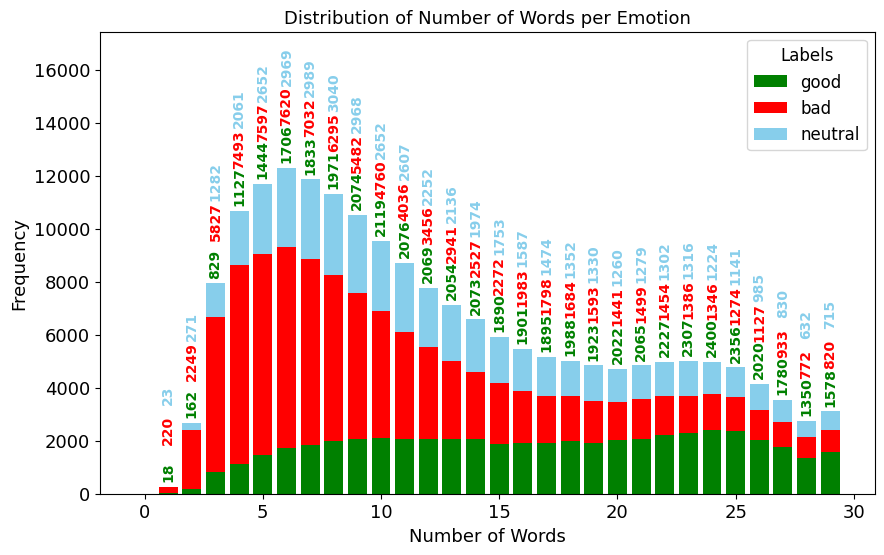

In [ ]:
# Count words in a text / distribution per emotion
def count_words(text):
    return len(text.split())

def plot_word_distribution(df):
    emotions = df['labels'].unique()

    emotion_colors = {
        'bad': 'red',
        'good': 'green',
        'neutral': 'skyblue'
    }
    text_emotion_colors = {
        'bad': 'red',
        'good': 'black',
        'neutral': 'blue'
    }
    fig, ax = plt.subplots(figsize=(10, 6))
    bins = np.arange(0, 31)

    stacked_heights = np.zeros((len(emotions), len(bins) - 1))

    for i, emotion in enumerate(emotions):
        filtered_df = df[df['labels'] == emotion]
        word_counts = filtered_df['tweets'].apply(count_words)
        hist, _ = np.histogram(word_counts, bins=bins)
        stacked_heights[i] = hist

    bottom = np.zeros(len(bins) - 1)
    for i, emotion in enumerate(emotions):
        ax.bar(bins[:-1], stacked_heights[i], label=emotion, bottom=bottom, color=emotion_colors[emotion])
        bottom += stacked_heights[i]

    for j in range(len(bins) - 1):
        y_offset = bottom[j]
        for i, emotion in enumerate(emotions):
            if stacked_heights[i][j] > 0:
                if emotion == 'good': y_offset += 200
                if emotion == 'bad': y_offset += 1400
                if emotion == 'neutral': y_offset += 1500

                ax.text(bins[j], y_offset, str(int(stacked_heights[i][j])),
                        ha='center', va='bottom', rotation=90, color=emotion_colors[emotion], fontweight='bold',fontsize=10)
                y_offset += 10

    legend_patches = [mpatches.Patch(color=emotion_colors[emotion], label=emotion) for emotion in emotions]
    ax.legend(handles=legend_patches)

    ax.set_title('Distribution of Number of Words per Emotion',fontsize=13)
    ax.set_xlabel('Number of Words',fontsize=13)
    ax.set_ylabel('Frequency',fontsize=13)

    ax.set_ylim(top=ax.get_ylim()[1] * 1.35)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    legend = plt.legend(title='Labels',fontsize=12)
    plt.setp(legend.get_title(),fontsize='large')
    plt.show()

plot_word_distribution(df)

In [ ]:
def identify_short_tweets(df):
    short_tweets = df[df['tweets'].apply(lambda x: count_words(x) <= 2)]
    return short_tweets

short_tweets_df = identify_short_tweets(df)
print("Short tweets with 3 words or less:")
print(short_tweets_df['tweets'])

Short tweets with 3 words or less:
133               chatgpt live
155                    talking
257           chatgpt #chatbot
390              chatgpt alpha
391       omfg#openai #chatgpt
                  ...         
218797             chatgpt api
219098      chatgpt generation
219142          signed chatgpt
219185        chatgpt tutorial
219274     alternative chatgpt
Name: tweets, Length: 2943, dtype: object


In [ ]:
def check_unique_values(df, column_name):
    unique_values = df[column_name].unique()
    print(f"Column '{column_name}' unique values: {unique_values}")

check_unique_values(df, 'labels')

Column 'labels' unique values: ['good' 'bad' 'neutral']


In [ ]:
# n-grams (bi-grams, tri-grams)
def generate_ngrams(text, exclude=[], n=2):
    tokens = text.split()
    ngrams = zip(*[tokens[i:] for i in range(n)])
    filtered_ngrams = [' '.join(ngram) for ngram in ngrams if ' '.join(ngram) not in exclude]
    return filtered_ngrams
exclude_list = ['going to','#ai #chatgpt','what is','#chatgpt openai','#chatgpt #openai','use chatgpt','asked #chatgpt','is not','#openai #chatgpt','did not','ai chatbot', 'using chatgpt','that is', "#chatgpt #ai", 'will not', 'does not', 'let us', 'chatgpt ai', 'i am', 'i have', 'it is', 'do not', 'artificial intelligence', 'asked chatgpt', 'chatgpt write', '#chatgpt write', 'here is']  # Replace with your excluded words

df['bi_grams'] = df['tweets'].apply(lambda x: generate_ngrams(x, exclude=exclude_list, n=2))
df['tri_grams'] = df['tweets'].apply(lambda x: generate_ngrams(x, n=3))

def count_ngrams(ngram_list):
    ngram_freq = {}
    for ngrams in ngram_list:
        for ngram in ngrams:
            if ngram in ngram_freq:
                ngram_freq[ngram] += 1
            else:
                ngram_freq[ngram] = 1
    return ngram_freq

positive_tweets = df[df['labels'] == 'good']
negative_tweets = df[df['labels'] == 'bad']

positive_bi_gram_freq = count_ngrams(positive_tweets['bi_grams'])
negative_bi_gram_freq = count_ngrams(negative_tweets['bi_grams'])

positive_tri_gram_freq = count_ngrams(positive_tweets['tri_grams'])
negative_tri_gram_freq = count_ngrams(negative_tweets['tri_grams'])



In [ ]:
# words_to_remove = [('that', 'is'), ('#chatgpt', '#ai'),('will','not'),('does','not'),('let','us'),('chatgpt','ai'),('will','not'),('i','am'),('i','have'),('will','not'),('it','is'),('do','not'),('artificial','intelligence'),('asked','chatgpt'),('chatgpt','write'),('will','not')]  # Add the word combinations you want to remove
# excluded_bigrams = {'that is',  "#chatgpt #ai", 'will not', 'does not', 'let us', 'chatgpt ai', 'i am', 'i have', 'it is', 'do not', 'artificial intelligence', 'asked chatgpt', 'chatgpt write', '#chatgpt write', 'here is'}  # Replace with your excluded words

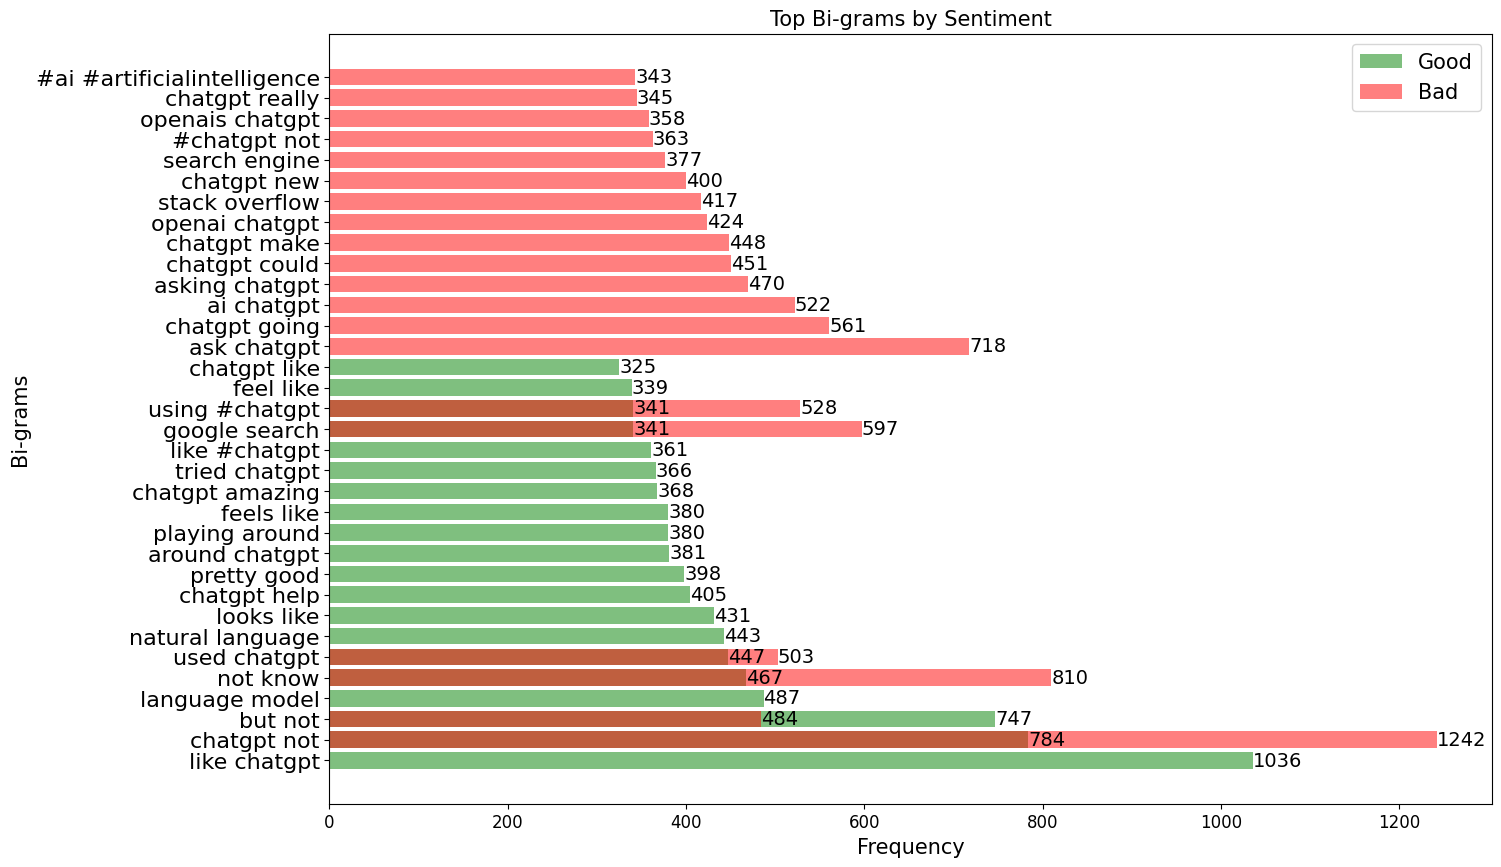

In [ ]:
#bi-grams
top_n = 20
top_positive_bi_grams = heapq.nlargest(top_n, positive_bi_gram_freq.items(), key=lambda x: x[1])
top_negative_bi_grams = heapq.nlargest(top_n, negative_bi_gram_freq.items(), key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(15, 10))

bars1 = ax.barh([x[0] for x in top_positive_bi_grams], [x[1] for x in top_positive_bi_grams], color='green', alpha=0.5, label='Good')
bars2 = ax.barh([x[0] for x in top_negative_bi_grams], [x[1] for x in top_negative_bi_grams], color='red', alpha=0.5, label='Bad')

ax.bar_label(bars1, [x[1] for x in top_positive_bi_grams],fontsize=14)
ax.bar_label(bars2, [x[1] for x in top_negative_bi_grams],fontsize=14)

plt.xlabel('Frequency',fontsize=15)
plt.ylabel('Bi-grams',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
legend = plt.legend(fontsize=15)
plt.title("Top Bi-grams by Sentiment",fontsize=15)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127881 (\N{PARTY POPPER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


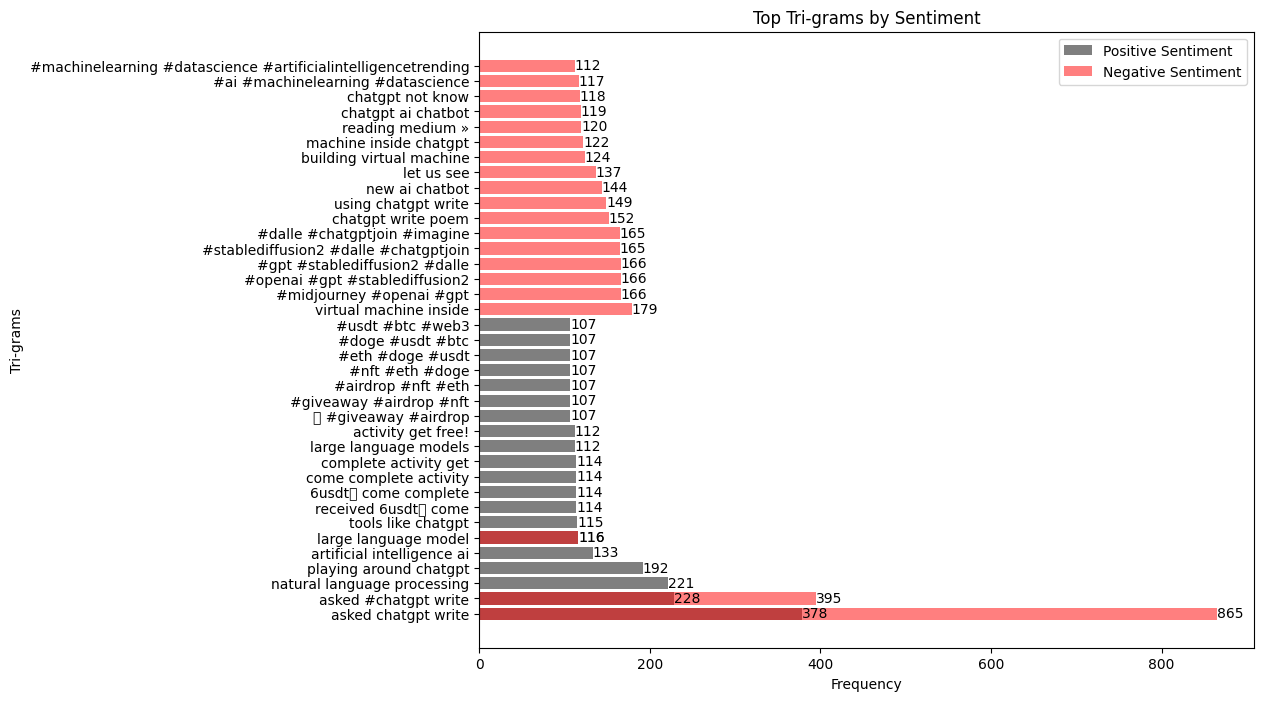

In [ ]:
#tri-grams
top_n = 20
top_positive_tri_grams = heapq.nlargest(top_n, positive_tri_gram_freq.items(), key=lambda x: x[1])
top_negative_tri_grams = heapq.nlargest(top_n, negative_tri_gram_freq.items(), key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(10, 8))

bars1 = ax.barh([x[0] for x in top_positive_tri_grams], [x[1] for x in top_positive_tri_grams], color='#000100', alpha=0.5, label='Positive Sentiment')
bars2 = ax.barh([x[0] for x in top_negative_tri_grams], [x[1] for x in top_negative_tri_grams], color='red', alpha=0.5, label='Negative Sentiment')

ax.bar_label(bars1, [x[1] for x in top_positive_tri_grams])
ax.bar_label(bars2, [x[1] for x in top_negative_tri_grams])

plt.xlabel('Frequency')
plt.ylabel('Tri-grams')
plt.legend()
plt.title("Top Tri-grams by Sentiment")
plt.show()

In [ ]:
df.head()

,id,tweets,labels,tags_count,tags_category,hashtags_count,hashtags_category,tokenized_tweet,bi_grams,tri_grams
3,3,thrilled share chatgpt new model optimized dia...,good,0,0,0,0,"[thrilled, share, chatgpt, new, model, optimiz...","[thrilled share, share chatgpt, chatgpt new, n...","[thrilled share chatgpt, share chatgpt new, ch..."
4,4,2 minutes ago released new chatgpt use right 👇,bad,1,1,0,0,"[2, minutes, ago, released, new, chatgpt, use,...","[2 minutes, minutes ago, ago released, release...","[2 minutes ago, minutes ago released, ago rele..."
5,5,launched chatgpt new ai system optimized dialo...,good,0,0,0,0,"[launched, chatgpt, new, ai, system, optimized...","[launched chatgpt, chatgpt new, new ai, ai sys...","[launched chatgpt new, chatgpt new ai, new ai ..."
6,6,2 minutes ago released new chatgpt use right 🤯,bad,1,1,0,0,"[2, minutes, ago, released, new, chatgpt, use,...","[2 minutes, minutes ago, ago released, release...","[2 minutes ago, minutes ago released, ago rele..."
7,7,chatgpt coming strong refusing help stalk some...,good,0,0,0,0,"[chatgpt, coming, strong, refusing, help, stal...","[chatgpt coming, coming strong, strong refusin...","[chatgpt coming strong, coming strong refusing..."


# **Models**

In [ ]:
X = df['tweets']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Set Metrics:
Accuracy: 82.82
Precision: 82.82
Recall: 82.82
F1 Score: 82.82
Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.86      0.87     71657
        good       0.82      0.84      0.83     71657
     neutral       0.79      0.78      0.78     71657

    accuracy                           0.83    214971
   macro avg       0.83      0.83      0.83    214971
weighted avg       0.83      0.83      0.83    214971

Test Set Metrics:
Accuracy: 76.26
Precision: 76.53
Recall: 76.26
F1 Score: 76.36
Classification Report:
               precision    recall  f1-score   support

         bad       0.88      0.84      0.86     17825
        good       0.72      0.77      0.74     10489
     neutral       0.62      0.61      0.61      9745

    accuracy                           0.76     38059
   macro avg       0.74      0.74      0.74     38059
weighted avg       0.77      0.76      0.76     38059

Confusion Matrix (Test Set)

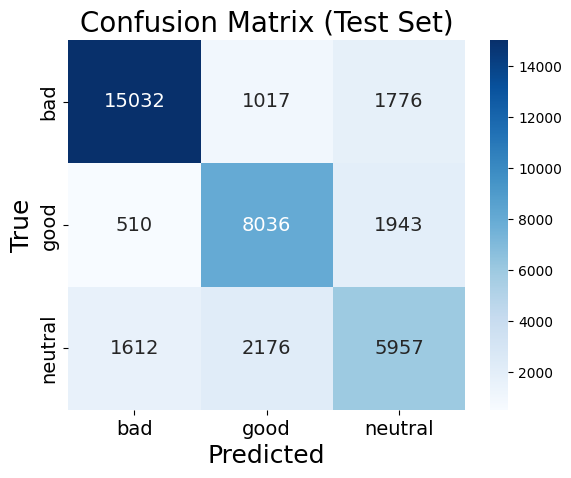

In [ ]:
#RF
# better performance metrics for neutral with oversampling #nb of leafs helped with overfitting (76-82) - test size doesnt matter
# Vectorize the data after splitting
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vect, y_train)

RF_Model = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=10, min_samples_split=5)
RF_Model.fit(X_train_resampled, y_train_resampled)

y_test_pred = RF_Model.predict(X_test_vect)
y_train_pred = RF_Model.predict(X_train_resampled)

#Evaluation train
RF_train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {RF_train_accuracy * 100:.2f}")
print(f"Precision: {train_precision * 100:.2f}")
print(f"Recall: {train_recall * 100:.2f}")
print(f"F1 Score: {train_f1 * 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

#Evaluation test
RF_test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {RF_test_accuracy * 100:.2f}")
print(f"Precision: {test_precision * 100:.2f}")
print(f"Recall: {test_recall * 100:.2f}")
print(f"F1 Score: {test_f1 * 100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))


conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)

heatmap = sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=RF_Model.classes_, yticklabels=RF_Model.classes_,
                      annot_kws={"size": 14})  # Increase annotation font size

plt.title('Confusion Matrix (Test Set)', fontsize=20)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)

heatmap.xaxis.set_tick_params(labelsize=14)
heatmap.yaxis.set_tick_params(labelsize=14)

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Accuracy: 86.82%
Train F1 Score: 86.92
Train Precision: 87.07
Train Recall: 86.82
Classification Report for Train Data:
               precision    recall  f1-score   support

         bad       0.93      0.91      0.92     71657
        good       0.88      0.85      0.86     41695
     neutral       0.75      0.80      0.78     38882

    accuracy                           0.87    152234
   macro avg       0.85      0.86      0.85    152234
weighted avg       0.87      0.87      0.87    152234

Test Accuracy: 82.70%
Test F1 Score: 82.81
Test Precision: 82.98
Test Recall: 82.70
Classification Report for Test Data:
               precision    recall  f1-score   support

         bad       0.91      0.90      0.90     17825
        good       0.84      0.80      0.82     10489
     neutral       0.68      0.73      0.70      9745

    accuracy                           0.83     38059
   macro avg       0.81      0.81      0.81     38059
weighted avg       0.83      0.83      0.83 

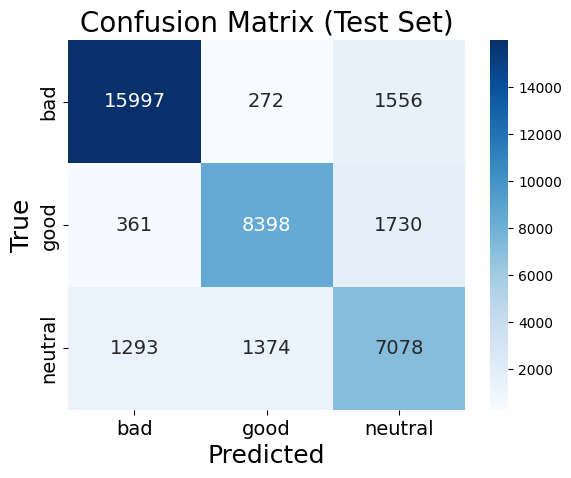

In [ ]:
#MaxEnt
#Close results as without tuning Grid Searched oversampler
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

rus = RandomOverSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

MaxEnt_Model = Pipeline([
    ('maxent', LogisticRegression(max_iter=10,solver='saga'))
])

MaxEnt_Model.fit(X_train_res, y_train_res)

y_train_pred = MaxEnt_Model.predict(X_train_tfidf)

y_test_pred = MaxEnt_Model.predict(X_test_tfidf)

#Evaluation train
MaxEnt_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {MaxEnt_train_accuracy * 100:.2f}%')

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
print(f'Train F1 Score: {train_f1* 100:.2f}')
print(f'Train Precision: {train_precision* 100:.2f}')
print(f'Train Recall: {train_recall* 100:.2f}')

train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Train Data:\n", train_report)

#Evaluation test
MaxEnt_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {MaxEnt_test_accuracy * 100:.2f}%')

test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {test_f1* 100:.2f}')
print(f'Test Precision: {test_precision* 100:.2f}')
print(f'Test Recall: {test_recall* 100:.2f}')

test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)

heatmap = sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=MaxEnt_Model.classes_, yticklabels=MaxEnt_Model.classes_,
                      annot_kws={"size": 14})  # Increase annotation font size

plt.title('Confusion Matrix (Test Set)', fontsize=20)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)

heatmap.xaxis.set_tick_params(labelsize=14)
heatmap.yaxis.set_tick_params(labelsize=14)

plt.show()

Epoch 1/5
3806/3806 [==============================] - 81s 21ms/step - loss: 0.9814 - accuracy: 0.5343 - val_loss: 0.8370 - val_accuracy: 0.6203 - lr: 5.0000e-05
Epoch 2/5
3806/3806 [==============================] - 74s 19ms/step - loss: 0.6789 - accuracy: 0.7158 - val_loss: 0.5382 - val_accuracy: 0.7915 - lr: 5.0000e-05
Epoch 3/5
3806/3806 [==============================] - 73s 19ms/step - loss: 0.5163 - accuracy: 0.8132 - val_loss: 0.4693 - val_accuracy: 0.8358 - lr: 5.0000e-05
Epoch 4/5
3806/3806 [==============================] - 73s 19ms/step - loss: 0.4525 - accuracy: 0.8486 - val_loss: 0.4454 - val_accuracy: 0.8466 - lr: 5.0000e-05
Epoch 5/5
4758/4758 [==============================] - 13s 3ms/step - loss: 0.3562 - accuracy: 0.8901
Train Accuracy: 89.01%
4758/4758 [==============================] - 11s 2ms/step
Train F1 Score: 88.98
Train Precision: 88.96
Train Recall: 89.01
Classification Report for Train Data:
               precision    recall  f1-score   support

         b

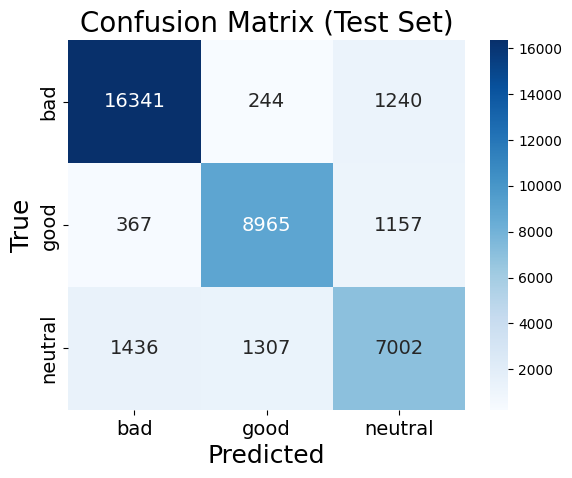

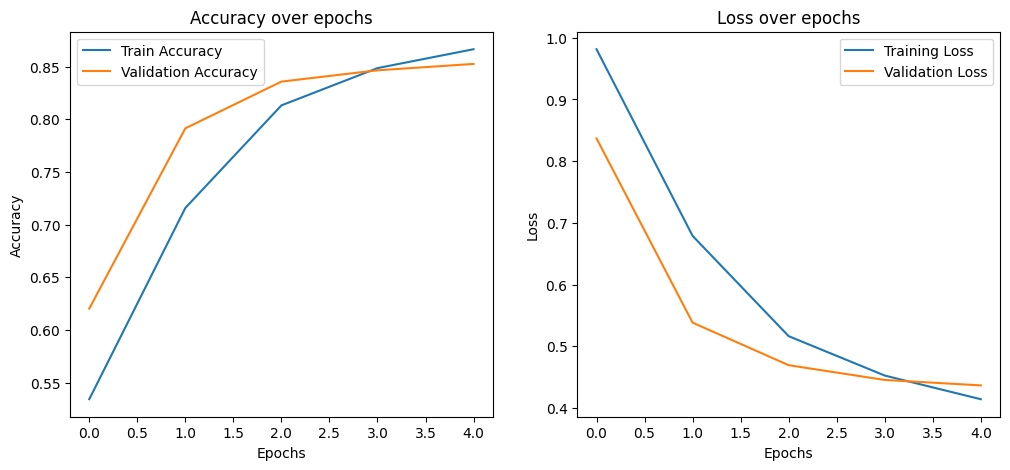

In [ ]:
# DNN
# lr=0.00005 32
max_words = 10000
max_len = 20
embedding_dim = 100

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

#Evaluation train
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

#Evaluation test
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)

heatmap = sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                      annot_kws={"size": 14})

plt.title('Confusion Matrix (Test Set)', fontsize=20)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)

heatmap.xaxis.set_tick_params(labelsize=14)
heatmap.yaxis.set_tick_params(labelsize=14)

plt.show()

# Training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#Text Classification
#LLM used for the project

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

good_tweets = resample(df[df['labels'] == 'good'], n_samples=10000, random_state=42)
bad_tweets = resample(df[df['labels'] == 'bad'], n_samples=10000, random_state=42)
neutral_tweets = resample(df[df['labels'] == 'neutral'], n_samples=10000, random_state=42)

sampled_df = pd.concat([good_tweets, bad_tweets, neutral_tweets])

sampled_df = sampled_df.sample(frac=1, random_state=42)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(sampled_df["tweets"], sampled_df['labels'], test_size=0.2, random_state=42)

texts = Xh_test.tolist()
true_labels = ['negative' if label == 'bad' else 'positive' if label == 'good' else label for label in yh_test]

predictions = sentiment_task(texts)
predicted_labels = [pred['label'] for pred in predictions]

#Evaluation
TC_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {TC_accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Evaluation Metrics:
Accuracy: 44.87
Precision: 47.88
Recall: 44.87
F1 Score: 44.33
Classification Report:
               precision    recall  f1-score   support

    negative       0.48      0.26      0.33      2023
     neutral       0.35      0.57      0.44      1968
    positive       0.60      0.52      0.56      2009

    accuracy                           0.45      6000
   macro avg       0.48      0.45      0.44      6000
weighted avg       0.48      0.45      0.44      6000



In [ ]:
#Zero shot classification
#balanced sampled data
classifier = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")

good_tweets = resample(df[df['labels'] == 'good'], n_samples=1000, random_state=42)
bad_tweets = resample(df[df['labels'] == 'bad'], n_samples=1000, random_state=42)
neutral_tweets = resample(df[df['labels'] == 'neutral'], n_samples=1000, random_state=42)

sampled_df = pd.concat([good_tweets, bad_tweets, neutral_tweets])

sampled_df = sampled_df.sample(frac=1, random_state=42)

candidate_labels = ['good', 'bad', 'neutral']

def classify_and_extract_label(text):
    result = classifier(text, candidate_labels, max_length=512, truncation=True)
    return result['labels'][0]

sampled_df['predicted_labels'] = sampled_df['tweets'].apply(classify_and_extract_label)

sampled_df['labels'] = sampled_df['labels'].astype(str)
sampled_df['predicted_labels'] = sampled_df['predicted_labels'].astype(str)

y_true = sampled_df['labels']
y_pred = sampled_df['predicted_labels']

#Evaluation
ZC_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {ZC_accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_true, y_pred))


config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics:
Accuracy: 41.73
Precision: 44.35
Recall: 41.73
F1 Score: 38.39
Classification Report:
               precision    recall  f1-score   support

         bad       0.52      0.31      0.39      1000
        good       0.39      0.77      0.51      1000
     neutral       0.42      0.18      0.25      1000

    accuracy                           0.42      3000
   macro avg       0.44      0.42      0.38      3000
weighted avg       0.44      0.42      0.38      3000



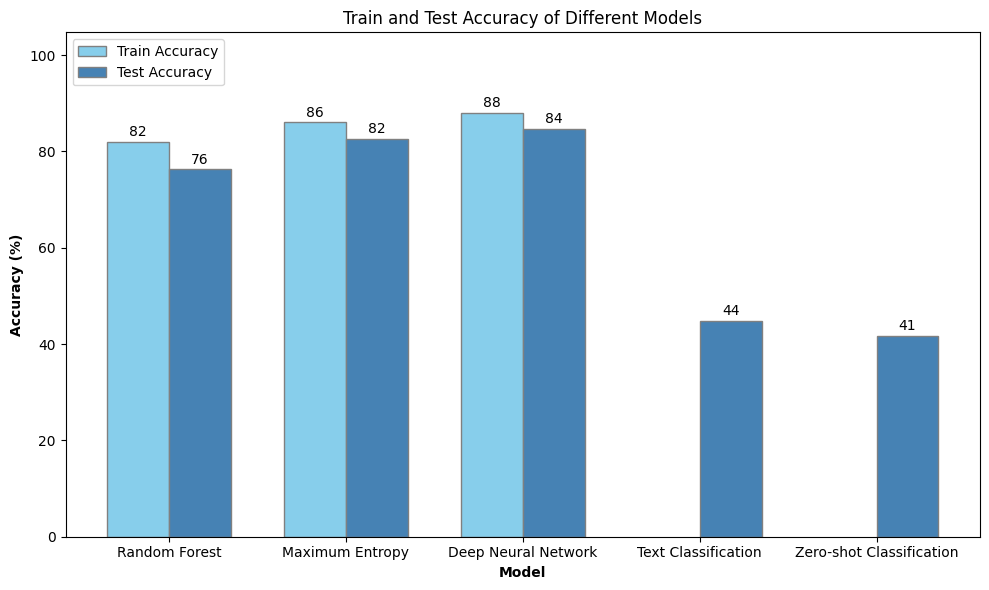

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_vis = {
  "Model": ["Random Forest", "Maximum Entropy", "Deep Neural Network", "Text Classification", "Zero-shot Classification"],
  "Train accuracy": [RF_train_accuracy*100, MaxEnt_train_accuracy*100, DNN_train_accuracy*100, None, None],
  "Test accuracy": [RF_test_accuracy*100, MaxEnt_test_accuracy*100, DNN_test_accuracy*100, TC_accuracy*100, ZC_accuracy*100]
}

visual_df = pd.DataFrame(data_vis)

visual_df['Train accuracy'] = visual_df['Train accuracy'].apply(lambda x: int(x) if pd.notna(x) else x)

bar_width = 0.35

r1 = np.arange(len(visual_df))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))

plt.bar(r1, visual_df['Train accuracy'], color='skyblue', width=bar_width, edgecolor='grey', label='Train Accuracy')
plt.bar(r2, visual_df['Test accuracy'], color='#4682B4', width=bar_width, edgecolor='grey', label='Test Accuracy')

for i in range(len(r1)):
    train_acc = visual_df['Train accuracy'][i]
    test_acc = visual_df['Test accuracy'][i]

    if pd.notna(train_acc):
        plt.text(r1[i], train_acc + 0.5, f'{int(train_acc)}', ha='center', va='bottom')

    plt.text(r2[i], test_acc + 0.5, f'{int(test_acc)}', ha='center', va='bottom')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Train and Test Accuracy of Different Models')

max_test_acc = max(visual_df['Test accuracy'])
plt.ylim(0, max_test_acc + 20)

plt.xticks([r + bar_width/2 for r in range(len(visual_df))], visual_df['Model'])


plt.legend()
plt.tight_layout()

plt.show()

# **No neutral models**

In [ ]:
df_no_neutrals = df[df['labels'] != 'neutral'].copy()

In [ ]:
X_no_neutrals = df_no_neutrals['tweets']
y_no_neutrals = df_no_neutrals['labels']

# Split the data into training and testing sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_no_neutrals, y_no_neutrals, test_size=0.2, random_state=42)

Train Set Metrics:
Accuracy: 92.35
Precision: 92.56
Recall: 92.35
F1 Score: 92.34
Classification Report:
               precision    recall  f1-score   support

         bad       0.96      0.89      0.92     71658
        good       0.90      0.96      0.93     71658

    accuracy                           0.92    143316
   macro avg       0.93      0.92      0.92    143316
weighted avg       0.93      0.92      0.92    143316

Test Set Metrics:
Accuracy: 89.51
Precision: 90.26
Recall: 89.51
F1 Score: 89.63
Classification Report:
               precision    recall  f1-score   support

         bad       0.95      0.87      0.91     17824
        good       0.81      0.93      0.87     10510

    accuracy                           0.90     28334
   macro avg       0.88      0.90      0.89     28334
weighted avg       0.90      0.90      0.90     28334

Confusion Matrix (Test Set):
 [[15588  2236]
 [  735  9775]]


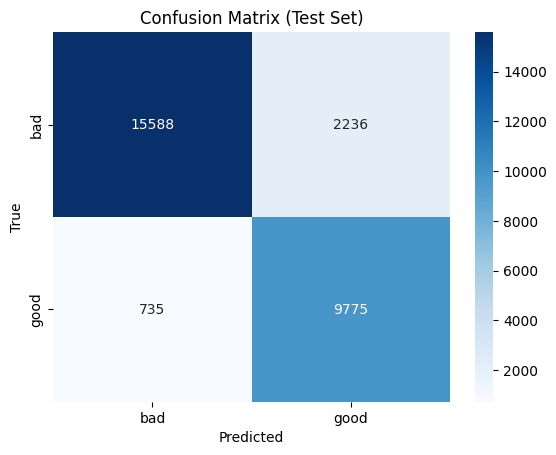

In [ ]:
# RF - No Tuning (Using Non-Neutral Data)
# Better performance metrics for neutral with oversampling (#nb of leafs helped with overfitting)

# Vectorize the data after splitting
vectorizer = TfidfVectorizer(max_features=10000)
X_train_nn_vect = vectorizer.fit_transform(X_train_nn)  # Use X_train_nn
X_test_vect = vectorizer.transform(X_test_nn)  # Use X_test_nn

# Apply Random OverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_nn_vect, y_train_nn)  # Use X_train_nn, y_train_nn

# Train the Random Forest classifier with parallel processing (using chosen hyperparameters)
RF_Model = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=10, min_samples_split=5)
RF_Model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set (use X_test_vect)
y_test_pred = RF_Model.predict(X_test_vect)
# Make predictions on the training set (resampled)
y_train_pred = RF_Model.predict(X_train_resampled)

# Evaluate the model on the training set (resampled) (no changes)
RF_train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {RF_train_accuracy * 100:.2f}")
print(f"Precision: {train_precision * 100:.2f}")
print(f"Recall: {train_recall * 100:.2f}")
print(f"F1 Score: {train_f1 * 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

# Evaluate the model on the test set (use y_test for all metrics)
RF_test_accuracy = accuracy_score(y_test_nn, y_test_pred)
test_precision = precision_score(y_test_nn, y_test_pred, average='weighted')
test_recall = recall_score(y_test_nn, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_nn, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {RF_test_accuracy * 100:.2f}")
print(f"Precision: {test_precision * 100:.2f}")
print(f"Recall: {test_recall * 100:.2f}")
print(f"F1 Score: {test_f1 * 100:.2f}")
print("Classification Report:\n", classification_report(y_test_nn, y_test_pred))

# Confusion matrix for the test set (use y_test)
conf_matrix_test = confusion_matrix(y_test_nn, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=RF_Model.classes_, yticklabels=RF_Model.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Accuracy: 96.26%
Train F1 Score: 96.27
Train Precision: 96.28
Train Recall: 96.26
Classification Report for Train Data:
               precision    recall  f1-score   support

         bad       0.97      0.97      0.97     71658
        good       0.94      0.96      0.95     41674

    accuracy                           0.96    113332
   macro avg       0.96      0.96      0.96    113332
weighted avg       0.96      0.96      0.96    113332

Test Accuracy: 94.97%
Test F1 Score: 94.97
Test Precision: 94.97
Test Recall: 94.97
Classification Report for Test Data:
               precision    recall  f1-score   support

         bad       0.96      0.96      0.96     17824
        good       0.93      0.93      0.93     10510

    accuracy                           0.95     28334
   macro avg       0.95      0.95      0.95     28334
weighted avg       0.95      0.95      0.95     28334

Confusion Matrix (Test Set):
 [[17095   729]
 [  697  9813]]


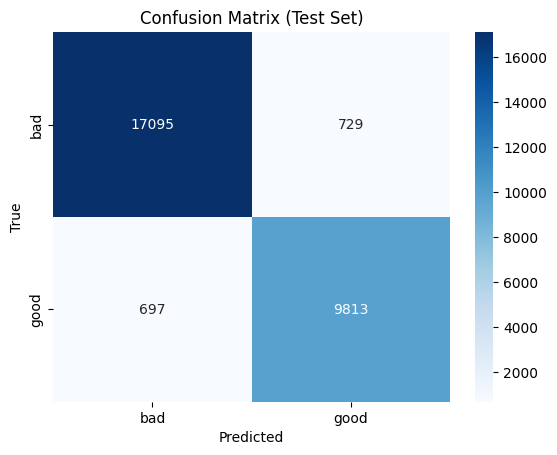

In [ ]:
#MaxEnt
# Convert the tokenized tweets into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_nn)
X_test_tfidf = vectorizer.transform(X_test_nn)

# Apply Random OverSampler to balance the classes
rus = RandomOverSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train_nn)  # Use y_train_nn

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression classifier
MaxEnt_Model = Pipeline([
    ('maxent', LogisticRegression(max_iter=10,solver='saga'))# Increased max_iter for convergence in large datasets
])

# Fit the model on the training data (use X_train_res, y_train_res after oversampling)
MaxEnt_Model.fit(X_train_res, y_train_res)

# Predict on the training data (use X_train_tfidf for predictions)
y_train_pred = MaxEnt_Model.predict(X_train_tfidf)

# Predict on the test data (use X_test_tfidf for predictions)
y_test_pred = MaxEnt_Model.predict(X_test_tfidf)

# Calculate and print train accuracy
MaxEnt_train_accuracy = accuracy_score(y_train_nn, y_train_pred)
print(f'Train Accuracy: {MaxEnt_train_accuracy * 100:.2f}%')

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(y_train_nn, y_train_pred, average='weighted')
train_precision = precision_score(y_train_nn, y_train_pred, average='weighted')
train_recall = recall_score(y_train_nn, y_train_pred, average='weighted')
print(f'Train F1 Score: {train_f1* 100:.2f}')
print(f'Train Precision: {train_precision* 100:.2f}')
print(f'Train Recall: {train_recall* 100:.2f}')

# Calculate and print classification report for train data
train_report = classification_report(y_train_nn, y_train_pred)
print("Classification Report for Train Data:\n", train_report)

# Calculate and print test accuracy
MaxEnt_test_accuracy = accuracy_score(y_test_nn, y_test_pred)
print(f'Test Accuracy: {MaxEnt_test_accuracy * 100:.2f}%')

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_nn, y_test_pred, average='weighted')
test_precision = precision_score(y_test_nn, y_test_pred, average='weighted')
test_recall = recall_score(y_test_nn, y_test_pred, average='weighted')
print(f'Test F1 Score: {test_f1* 100:.2f}')
print(f'Test Precision: {test_precision* 100:.2f}')
print(f'Test Recall: {test_recall* 100:.2f}')

# Calculate and print classification report for test data
test_report = classification_report(y_test_nn, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_nn, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=MaxEnt_Model.classes_, yticklabels=MaxEnt_Model.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1/5
2834/2834 [==============================] - 61s 21ms/step - loss: 0.5615 - accuracy: 0.7208 - val_loss: 0.4020 - val_accuracy: 0.8372 - lr: 5.0000e-05
Epoch 2/5
2834/2834 [==============================] - 58s 20ms/step - loss: 0.2694 - accuracy: 0.9030 - val_loss: 0.1977 - val_accuracy: 0.9247 - lr: 5.0000e-05
Epoch 3/5
2834/2834 [==============================] - 58s 21ms/step - loss: 0.1617 - accuracy: 0.9483 - val_loss: 0.1713 - val_accuracy: 0.9387 - lr: 5.0000e-05
Epoch 4/5
2834/2834 [==============================] - 60s 21ms/step - loss: 0.1271 - accuracy: 0.9619 - val_loss: 0.1633 - val_accuracy: 0.9439 - lr: 5.0000e-05
Epoch 5/5
3542/3542 [==============================] - 14s 4ms/step - loss: 0.0928 - accuracy: 0.9735
Train Accuracy: 97.35%
3542/3542 [==============================] - 13s 4ms/step
Train F1 Score: 97.35
Train Precision: 97.35
Train Recall: 97.35
Classification Report for Train Data:
               precision    recall  f1-score   support

         b

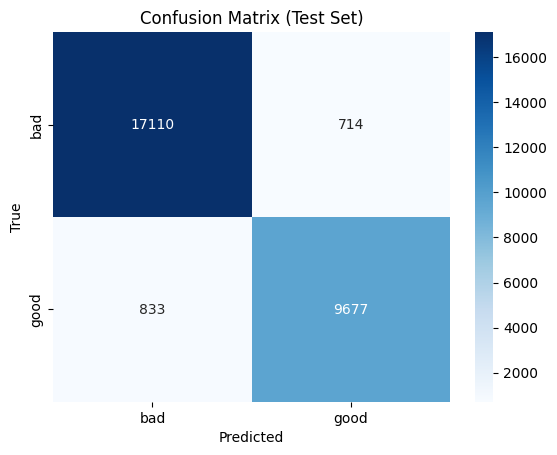

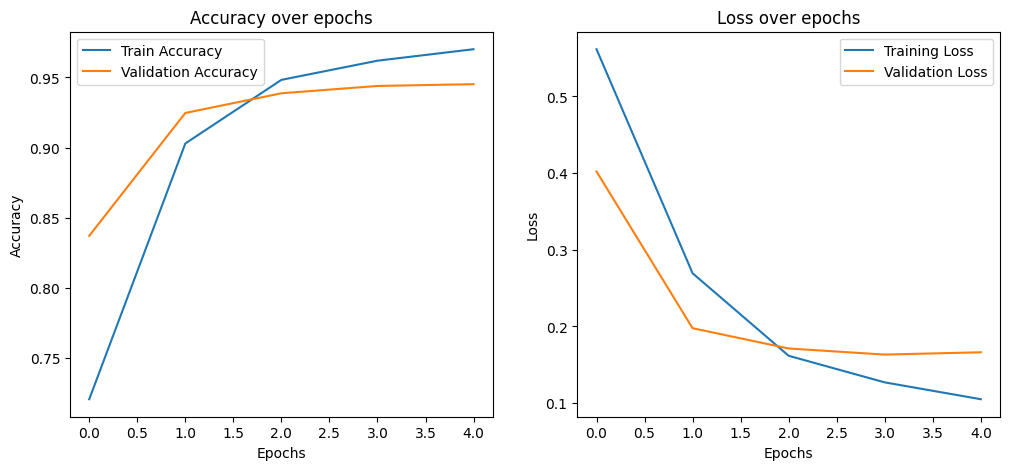

In [ ]:
# DNN (Using Non-Neutral Data)
# lr=0.00005 32

# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels (assuming labels are already 0 or 1)
label_encoder = LabelEncoder()  # No need for to_categorical for binary classification
y_train_encoded = label_encoder.fit_transform(y_train_nn)
y_test_encoded = label_encoder.transform(y_test_nn)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_nn)

# Text sequences from training data
X_train_seq = tokenizer.texts_to_sequences(X_train_nn)

# Text sequences from test data
X_test_seq = tokenizer.texts_to_sequences(X_test_nn)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model (binary classification output)
DNN_Model = Sequential([
  Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_encoded)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = (train_predictions > 0.5).astype(int)  # Threshold for binary classification
train_original_classes = np.argmax(y_train_categorical, axis=1)
# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')
# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Use y_test_encoded for evaluation since it contains the binary labels
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_encoded)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype(int)  # Threshold for binary classification

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#Text Classification
#LLM used for the project

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

good_tweets = resample(df_no_neutrals[df_no_neutrals['labels'] == 'good'], n_samples=10000, random_state=42)
bad_tweets = resample(df_no_neutrals[df_no_neutrals['labels'] == 'bad'], n_samples=10000, random_state=42)

# Concatenate the sampled tweets
sampled_df = pd.concat([good_tweets, bad_tweets])

# Shuffle the dataframe
sampled_df = sampled_df.sample(frac=1, random_state=42)

Xh_train_nn, Xh_test_nn, yh_train_nn, yh_test_nn = train_test_split(sampled_df['tweets'], sampled_df['labels'], test_size=0.2, random_state=42)

texts = Xh_test_nn.tolist()
true_labels = ['negative' if label == 'bad' else 'positive' if label == 'good' else label for label in yh_test_nn]

predictions = sentiment_task(texts)
predicted_labels = [pred['label'] for pred in predictions]
# Evaluate the modelT
TC_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {TC_accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Evaluation Metrics:
Accuracy: 40.88
Precision: 77.76
Recall: 40.88
F1 Score: 52.85
Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.27      0.39      1945
     neutral       0.00      0.00      0.00         0
    positive       0.85      0.54      0.66      2055

    accuracy                           0.41      4000
   macro avg       0.52      0.27      0.35      4000
weighted avg       0.78      0.41      0.53      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

In [ ]:
#Zero shot classification
#balanced sampled data
classifier = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")

# Sample 1000 tweets from each class (good, bad, neutral)
good_tweets = resample(df_no_neutrals[df_no_neutrals['labels'] == 'good'], n_samples=1000, random_state=42)
bad_tweets = resample(df_no_neutrals[df_no_neutrals['labels'] == 'bad'], n_samples=1000, random_state=42)

# Concatenate the sampled tweets
sampled_df = pd.concat([good_tweets, bad_tweets])

# Shuffle the dataframe
sampled_df = sampled_df.sample(frac=1, random_state=42)

candidate_labels = ['good', 'bad']

def classify_and_extract_label(text):
    result = classifier(text, candidate_labels, max_length=512, truncation=True)
    return result['labels'][0]

# Apply the classifier to each tweet
sampled_df['predicted_labels'] = sampled_df['tweets'].apply(classify_and_extract_label)

# Ensure all labels and predictions are strings
sampled_df['labels'] = sampled_df['labels'].astype(str)
sampled_df['predicted_labels'] = sampled_df['predicted_labels'].astype(str)

# Get the ground truth labels and predicted labels
y_true_zc = sampled_df['labels']
y_pred_zc = sampled_df['predicted_labels']

# Evaluate the model
ZC_accuracy = accuracy_score(y_true_zc, y_pred_zc)
precision = precision_score(y_true_zc, y_pred_zc, average='weighted')
recall = recall_score(y_true_zc, y_pred_zc, average='weighted')
f1 = f1_score(y_true_zc, y_pred_zc, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {ZC_accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_true_zc, y_pred_zc))


config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:01<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics:
Accuracy: 60.60
Precision: 64.57
Recall: 60.60
F1 Score: 57.72
Classification Report:
               precision    recall  f1-score   support

         bad       0.72      0.34      0.47      1000
        good       0.57      0.87      0.69      1000

    accuracy                           0.61      2000
   macro avg       0.65      0.61      0.58      2000
weighted avg       0.65      0.61      0.58      2000



In [ ]:
#separator

# **Random Forest Classifier**

Train Set Metrics:
Accuracy: 82.72
Precision: 82.71
Recall: 82.72
F1 Score: 82.71
Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.87      0.87     71657
        good       0.82      0.84      0.83     71657
     neutral       0.79      0.78      0.78     71657

    accuracy                           0.83    214971
   macro avg       0.83      0.83      0.83    214971
weighted avg       0.83      0.83      0.83    214971

Confusion Matrix (Train Set):
 [[62063  3797  5797]
 [ 2532 59975  9150]
 [ 6646  9234 55777]]


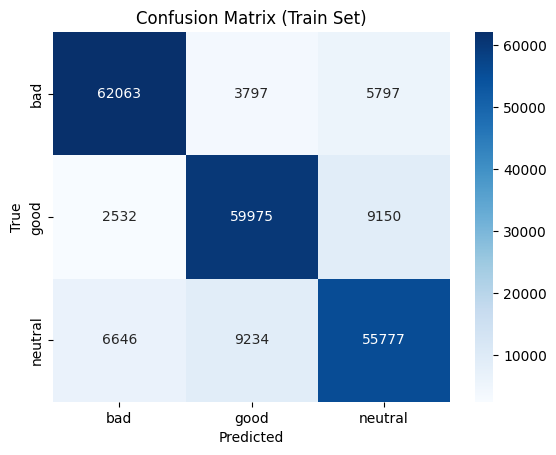

Test Set Metrics:
Accuracy: 76.33
Precision: 76.54
Recall: 76.33
F1 Score: 76.41
Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.85      0.86     17825
        good       0.72      0.76      0.74     10489
     neutral       0.62      0.61      0.61      9745

    accuracy                           0.76     38059
   macro avg       0.74      0.74      0.74     38059
weighted avg       0.77      0.76      0.76     38059

Confusion Matrix (Test Set):
 [[15094  1004  1727]
 [  524  7994  1971]
 [ 1641  2141  5963]]


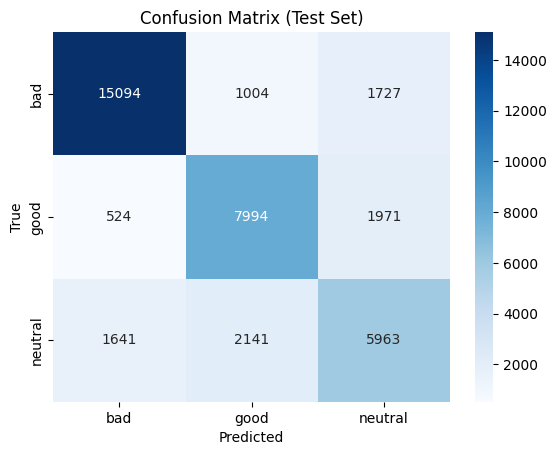

In [ ]:
# better performance metrics for neutral with oversampling #nb of leafs helped with overfitting (76-82) - test size doesnt matter
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
features = vectorizer.fit_transform(df['tweets'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.2, random_state=42)

# Apply Random OverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Random Forest classifier with parallel processing
RF_Model = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=10, min_samples_split=5)  # Adjust n_estimators as needed
RF_Model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = RF_Model.predict(X_test)
# Make predictions on the training set (resampled)
y_train_pred = RF_Model.predict(X_train_resampled)

# Evaluate the model on the training set (resampled)
RF_train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {RF_train_accuracy* 100:.2f}")
print(f"Precision: {train_precision* 100:.2f}")
print(f"Recall: {train_recall* 100:.2f}")
print(f"F1 Score: {train_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

# Confusion matrix for the training set (resampled)
conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred)
print("Confusion Matrix (Train Set):\n", conf_matrix_train)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=RF_Model.classes_, yticklabels=RF_Model.classes_)
plt.title('Confusion Matrix (Train Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate the model on the test set
RF_test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {RF_test_accuracy* 100:.2f}")
print(f"Precision: {test_precision* 100:.2f}")
print(f"Recall: {test_recall* 100:.2f}")
print(f"F1 Score: {test_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=RF_Model.classes_, yticklabels=RF_Model.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## tests

Train Set Metrics:
Accuracy: 79.44
Precision: 79.33
Recall: 79.44
F1 Score: 79.35
Classification Report:
               precision    recall  f1-score   support

         bad       0.83      0.86      0.85     71657
        good       0.79      0.81      0.80     71657
     neutral       0.76      0.71      0.73     71657

    accuracy                           0.79    214971
   macro avg       0.79      0.79      0.79    214971
weighted avg       0.79      0.79      0.79    214971

Test Set Metrics:
Accuracy: 75.50
Precision: 75.64
Recall: 75.50
F1 Score: 75.54
Classification Report:
               precision    recall  f1-score   support

         bad       0.86      0.84      0.85     17825
        good       0.71      0.76      0.73     10489
     neutral       0.61      0.59      0.60      9745

    accuracy                           0.76     38059
   macro avg       0.73      0.73      0.73     38059
weighted avg       0.76      0.76      0.76     38059

Confusion Matrix (Test Set)

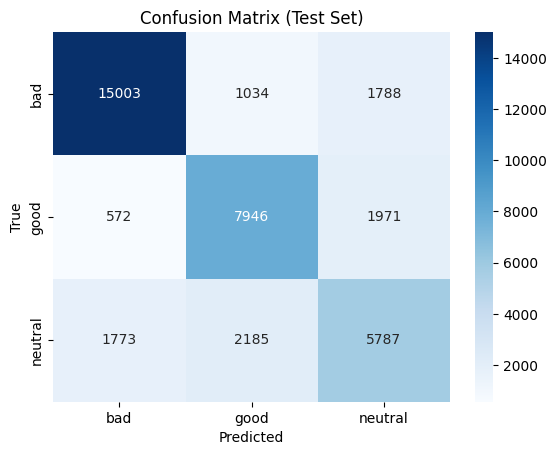

In [ ]:
# true bootstrap
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
features = vectorizer.fit_transform(df['tweets'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.2, random_state=42)

# Apply Random OverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Random Forest classifier with parallel processing
clf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True, max_features='sqrt', min_samples_leaf=10, min_samples_split=5)  # Adjust n_estimators as needed
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)
# Make predictions on the training set (resampled)
y_train_pred = clf.predict(X_train_resampled)

# Evaluate the model on the training set (resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {train_accuracy* 100:.2f}")
print(f"Precision: {train_precision* 100:.2f}")
print(f"Recall: {train_recall* 100:.2f}")
print(f"F1 Score: {train_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy* 100:.2f}")
print(f"Precision: {test_precision* 100:.2f}")
print(f"Recall: {test_recall* 100:.2f}")
print(f"F1 Score: {test_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Train Set Metrics:
Accuracy: 82.57
Precision: 82.56
Recall: 82.57
F1 Score: 82.56
Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.86      0.87     71657
        good       0.82      0.84      0.83     71657
     neutral       0.79      0.78      0.78     71657

    accuracy                           0.83    214971
   macro avg       0.83      0.83      0.83    214971
weighted avg       0.83      0.83      0.83    214971

Test Set Metrics:
Accuracy: 76.22
Precision: 76.48
Recall: 76.22
F1 Score: 76.32
Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.84      0.86     17825
        good       0.72      0.76      0.74     10489
     neutral       0.61      0.62      0.62      9745

    accuracy                           0.76     38059
   macro avg       0.74      0.74      0.74     38059
weighted avg       0.76      0.76      0.76     38059

Confusion Matrix (Test Set)

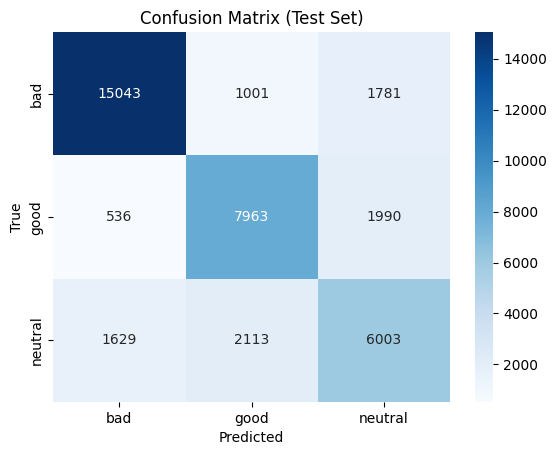

In [ ]:
# trees 50
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
features = vectorizer.fit_transform(df['tweets'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.2, random_state=42)

# Apply Random OverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Random Forest classifier with parallel processing
clf = RandomForestClassifier(n_estimators=50, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=10, min_samples_split=5)  # Adjust n_estimators as needed
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)
# Make predictions on the training set (resampled)
y_train_pred = clf.predict(X_train_resampled)

# Evaluate the model on the training set (resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {train_accuracy* 100:.2f}")
print(f"Precision: {train_precision* 100:.2f}")
print(f"Recall: {train_recall* 100:.2f}")
print(f"F1 Score: {train_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy* 100:.2f}")
print(f"Precision: {test_precision* 100:.2f}")
print(f"Recall: {test_recall* 100:.2f}")
print(f"F1 Score: {test_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Train Set Metrics:
Accuracy: 88.53
Precision: 88.63
Recall: 88.53
F1 Score: 88.55
Classification Report:
               precision    recall  f1-score   support

         bad       0.92      0.88      0.90     71657
        good       0.88      0.89      0.89     71657
     neutral       0.85      0.88      0.86     71657

    accuracy                           0.89    214971
   macro avg       0.89      0.89      0.89    214971
weighted avg       0.89      0.89      0.89    214971

Test Set Metrics:
Accuracy: 77.03
Precision: 77.18
Recall: 77.03
F1 Score: 77.08
Classification Report:
               precision    recall  f1-score   support

         bad       0.88      0.85      0.87     17825
        good       0.73      0.77      0.75     10489
     neutral       0.63      0.62      0.62      9745

    accuracy                           0.77     38059
   macro avg       0.74      0.75      0.75     38059
weighted avg       0.77      0.77      0.77     38059

Confusion Matrix (Test Set)

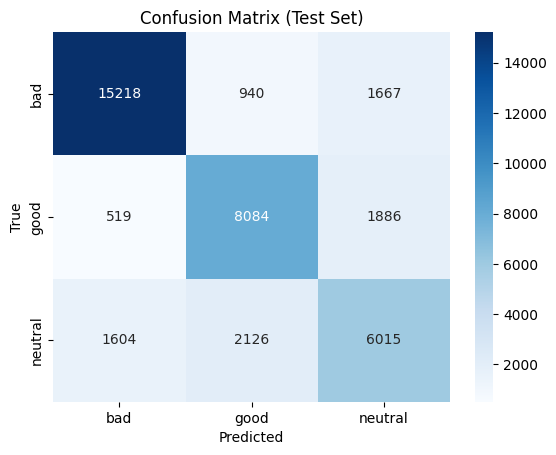

In [ ]:
# 5 leaf samples split
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
features = vectorizer.fit_transform(df['tweets'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.2, random_state=42)

# Apply Random OverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Random Forest classifier with parallel processing
clf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=5, min_samples_split=5)  # Adjust n_estimators as needed
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)
# Make predictions on the training set (resampled)
y_train_pred = clf.predict(X_train_resampled)

# Evaluate the model on the training set (resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {train_accuracy* 100:.2f}")
print(f"Precision: {train_precision* 100:.2f}")
print(f"Recall: {train_recall* 100:.2f}")
print(f"F1 Score: {train_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy* 100:.2f}")
print(f"Precision: {test_precision* 100:.2f}")
print(f"Recall: {test_recall* 100:.2f}")
print(f"F1 Score: {test_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Train Set Metrics:
Accuracy: 99.87
Precision: 99.87
Recall: 99.87
F1 Score: 99.87
Classification Report:
               precision    recall  f1-score   support

         bad       1.00      1.00      1.00     71657
        good       1.00      1.00      1.00     71657
     neutral       1.00      1.00      1.00     71657

    accuracy                           1.00    214971
   macro avg       1.00      1.00      1.00    214971
weighted avg       1.00      1.00      1.00    214971

Test Set Metrics:
Accuracy: 77.81
Precision: 77.40
Recall: 77.81
F1 Score: 77.48
Classification Report:
               precision    recall  f1-score   support

         bad       0.86      0.88      0.87     17825
        good       0.73      0.79      0.76     10489
     neutral       0.67      0.58      0.62      9745

    accuracy                           0.78     38059
   macro avg       0.75      0.75      0.75     38059
weighted avg       0.77      0.78      0.77     38059

Confusion Matrix (Test Set)

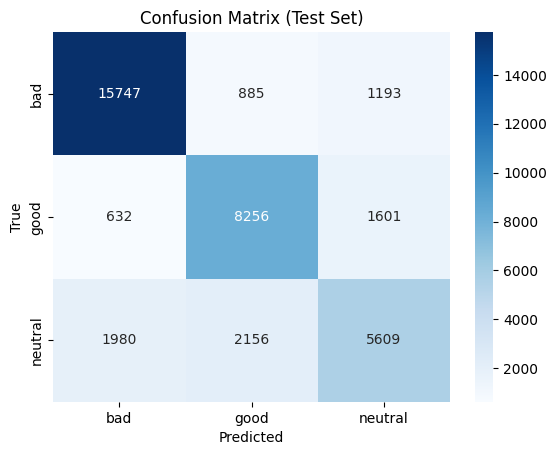

In [ ]:
#1 leaf samples split
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
features = vectorizer.fit_transform(df['tweets'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.2, random_state=42)

# Apply Random OverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the Random Forest classifier with parallel processing
clf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=1, min_samples_split=5)  # Adjust n_estimators as needed
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)
# Make predictions on the training set (resampled)
y_train_pred = clf.predict(X_train_resampled)

# Evaluate the model on the training set (resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
print("Train Set Metrics:")
print(f"Accuracy: {train_accuracy* 100:.2f}")
print(f"Precision: {train_precision* 100:.2f}")
print(f"Recall: {train_recall* 100:.2f}")
print(f"F1 Score: {train_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy* 100:.2f}")
print(f"Precision: {test_precision* 100:.2f}")
print(f"Recall: {test_recall* 100:.2f}")
print(f"F1 Score: {test_f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### RF other results

In [ ]:
"""
#The train acc=1 indicating overfitting
# Vectorize the tokenized tweets
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
features = vectorizer.fit_transform(df['tweets'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.2, random_state=42)

# Train the Random Forest classifier with parallel processing
clf = RandomForestClassifier(n_estimators=97, random_state=42, bootstrap=False, max_features='sqrt', min_samples_leaf=1, min_samples_split=6)  # Adjust n_estimators as needed
clf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
y_pred_train =clf.predict(X_train)
print("Accuracy for train:", accuracy_score(y_test, y_pred_train))
print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
"""

Accuracy: 0.783494048713839
Classification Report:
               precision    recall  f1-score   support

         bad       0.87      0.88      0.87     17825
        good       0.73      0.80      0.76     10489
     neutral       0.67      0.59      0.63      9745

    accuracy                           0.78     38059
   macro avg       0.76      0.76      0.76     38059
weighted avg       0.78      0.78      0.78     38059



In [ ]:
# # Vectorize the tokenized tweets
# vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
# features = vectorizer.fit_transform(df['tweets'])

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, df['labels'], test_size=0.9, random_state=42)

# # Train the Random Forest classifier with parallel processing
# clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=200)  # Adjust n_estimators as needed
# clf.fit(X_train, y_train)

# # Make predictions and evaluate the model
# y_pred = clf.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# def load_glove_embeddings(file_path):
#     embeddings_index = {}
#     with open(file_path, encoding='utf-8') as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             coefs = np.asarray(values[1:], dtype='float32')
#             embeddings_index[word] = coefs
#     return embeddings_index
# glove_file = '/content/drive/MyDrive/FYP - SA - James & Stephan/Codes/glove.twitter.27B/glove.twitter.27B.50d.txt'
# embeddings_index = load_glove_embeddings(glove_file)

In [ ]:
# def average_glove_vectors(tokens, embeddings_index, vector_size=100):
#     avg_vector = np.zeros(vector_size)
#     num_tokens = 0
#     for token in tokens:
#         if token in embeddings_index:
#             avg_vector = np.add(avg_vector, embeddings_index[token])
#             num_tokens += 1
#     if num_tokens > 0:
#         avg_vector = np.divide(avg_vector, num_tokens)
#     return avg_vector

# # Vectorize the tweets
# df['tweet_vector'] = df['tokenized_tweet'].apply(lambda x: average_glove_vectors(x, embeddings_index, vector_size=50))
# X = np.array(df['tweet_vector'].tolist())
# y = df['labels']

#**Maximum Entropy**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Accuracy: 86.84%
Train F1 Score: 86.94
Train Precision: 87.08
Train Recall: 86.84
Classification Report for Train Data:
               precision    recall  f1-score   support

         bad       0.93      0.91      0.92     71657
        good       0.88      0.85      0.86     41695
     neutral       0.75      0.80      0.78     38882

    accuracy                           0.87    152234
   macro avg       0.85      0.86      0.85    152234
weighted avg       0.87      0.87      0.87    152234

Confusion Matrix (Train Set):
 [[65543  1063  5051]
 [ 1095 35516  5084]
 [ 3766  3970 31146]]


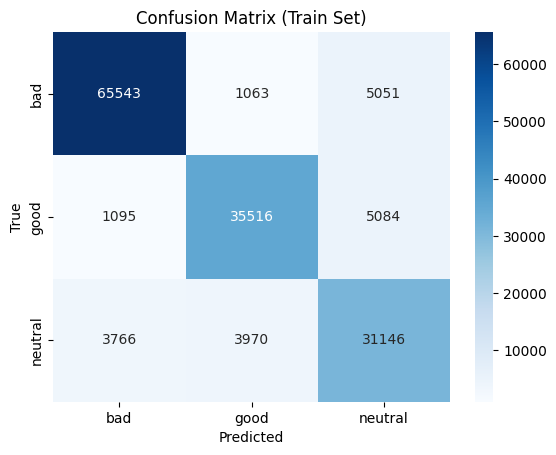

Test Accuracy: 82.65%
Test F1 Score: 82.76
Test Precision: 82.93
Test Recall: 82.65
Classification Report for Test Data:
               precision    recall  f1-score   support

         bad       0.91      0.90      0.90     17825
        good       0.84      0.80      0.82     10489
     neutral       0.68      0.73      0.70      9745

    accuracy                           0.83     38059
   macro avg       0.81      0.81      0.81     38059
weighted avg       0.83      0.83      0.83     38059

Confusion Matrix (Test Set):
 [[16001   266  1558]
 [  364  8386  1739]
 [ 1304  1372  7069]]


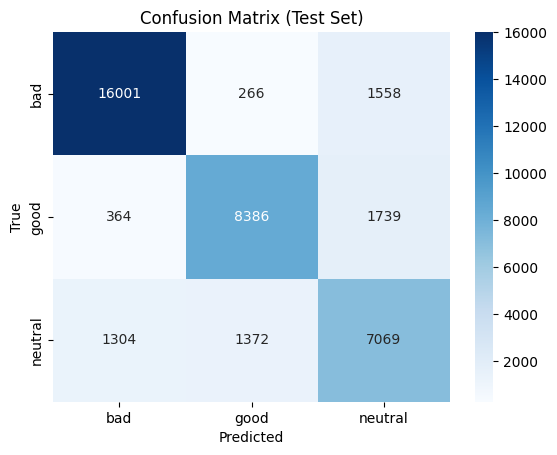

In [ ]:
#Close results as without tuning Grid Searched oversampler
X = df['tweets']
y = df['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the tokenized tweets into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply Random OverSampler to balance the classes
rus = RandomOverSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression classifier
MaxEnt_Model = Pipeline([
    ('maxent', LogisticRegression(max_iter=10,solver='saga'))  # Increased max_iter for convergence in large datasets
])

# Fit the model on the training data
MaxEnt_Model.fit(X_train_res, y_train_res)

# Predict on the training data for evaluation
y_train_pred = MaxEnt_Model.predict(X_train_tfidf)

# Predict on the test data
y_test_pred = MaxEnt_Model.predict(X_test_tfidf)

# Calculate and print train accuracy
MaxEnt_train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {MaxEnt_train_accuracy * 100:.2f}%')

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
print(f'Train F1 Score: {train_f1* 100:.2f}')
print(f'Train Precision: {train_precision* 100:.2f}')
print(f'Train Recall: {train_recall* 100:.2f}')

# Calculate and print classification report for train data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Train Data:\n", train_report)

# Confusion matrix for the training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix (Train Set):\n", conf_matrix_train)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=MaxEnt_Model.classes_, yticklabels=MaxEnt_Model.classes_)
plt.title('Confusion Matrix (Train Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate and print test accuracy
MaxEnt_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {MaxEnt_test_accuracy * 100:.2f}%')

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {test_f1* 100:.2f}')
print(f'Test Precision: {test_precision* 100:.2f}')
print(f'Test Recall: {test_recall* 100:.2f}')

# Calculate and print classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=MaxEnt_Model.classes_, yticklabels=MaxEnt_Model.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## test

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Accuracy: 86.67%
Train F1 Score: 86.74
Train Precision: 86.87
Train Recall: 86.67
Classification Report for Train Data:
               precision    recall  f1-score   support

         bad       0.92      0.92      0.92     71657
        good       0.88      0.84      0.86     41695
     neutral       0.75      0.80      0.77     38882

    accuracy                           0.87    152234
   macro avg       0.85      0.85      0.85    152234
weighted avg       0.87      0.87      0.87    152234

Test Accuracy: 82.63%
Test F1 Score: 82.70
Test Precision: 82.84
Test Recall: 82.63
Classification Report for Test Data:
               precision    recall  f1-score   support

         bad       0.90      0.90      0.90     17825
        good       0.84      0.79      0.82     10489
     neutral       0.68      0.72      0.70      9745

    accuracy                           0.83     38059
   macro avg       0.81      0.81      0.81     38059
weighted avg       0.83      0.83      0.83 

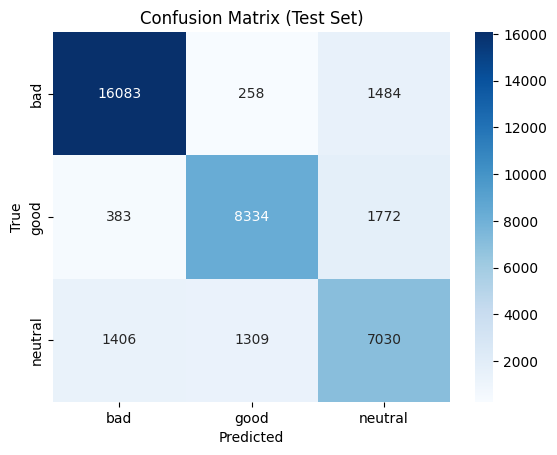

In [ ]:
#5 iterations
X = df['tweets']
y = df['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the tokenized tweets into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply Random OverSampler to balance the classes
rus = RandomOverSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression classifier
pipeline = Pipeline([
    ('maxent', LogisticRegression(max_iter=5,solver='saga'))  # Increased max_iter for convergence in large datasets
])

# Fit the model on the training data
pipeline.fit(X_train_res, y_train_res)

# Predict on the training data for evaluation
y_train_pred = pipeline.predict(X_train_tfidf)

# Predict on the test data
y_test_pred = pipeline.predict(X_test_tfidf)

# Calculate and print train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Calculate and print classification report for train data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Train Data:\n", train_report)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Calculate and print classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Accuracy: 86.85%
Train F1 Score: 86.93
Train Precision: 87.06
Train Recall: 86.85
Classification Report for Train Data:
               precision    recall  f1-score   support

         bad       0.93      0.92      0.92     71657
        good       0.87      0.85      0.86     41695
     neutral       0.76      0.80      0.78     38882

    accuracy                           0.87    152234
   macro avg       0.85      0.86      0.85    152234
weighted avg       0.87      0.87      0.87    152234

Test Accuracy: 82.68%
Test F1 Score: 82.77
Test Precision: 82.91
Test Recall: 82.68
Classification Report for Test Data:
               precision    recall  f1-score   support

         bad       0.90      0.90      0.90     17825
        good       0.83      0.80      0.82     10489
     neutral       0.68      0.72      0.70      9745

    accuracy                           0.83     38059
   macro avg       0.81      0.81      0.81     38059
weighted avg       0.83      0.83      0.83 

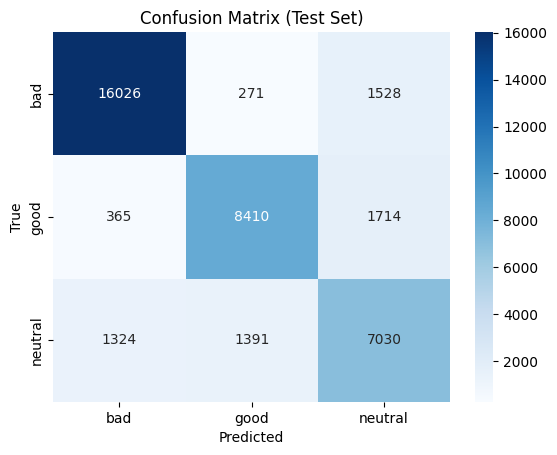

In [ ]:
#20 iterations
X = df['tweets']
y = df['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the tokenized tweets into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply Random OverSampler to balance the classes
rus = RandomOverSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression classifier
pipeline = Pipeline([
    ('maxent', LogisticRegression(max_iter=20,solver='saga'))  # Increased max_iter for convergence in large datasets
])

# Fit the model on the training data
pipeline.fit(X_train_res, y_train_res)

# Predict on the training data for evaluation
y_train_pred = pipeline.predict(X_train_tfidf)

# Predict on the test data
y_test_pred = pipeline.predict(X_test_tfidf)

# Calculate and print train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Calculate and print classification report for train data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Train Data:\n", train_report)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Calculate and print classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 63.75%
Train F1 Score: 64.92
Train Precision: 68.10
Train Recall: 63.75
Classification Report for Train Data:
               precision    recall  f1-score   support

         bad       0.80      0.68      0.74     71657
        good       0.72      0.56      0.63     41695
     neutral       0.42      0.63      0.50     38882

    accuracy                           0.64    152234
   macro avg       0.65      0.63      0.62    152234
weighted avg       0.68      0.64      0.65    152234

Test Accuracy: 63.07%
Test F1 Score: 64.27
Test Precision: 67.45
Test Recall: 63.07
Classification Report for Test Data:
               precision    recall  f1-score   support

         bad       0.80      0.68      0.74     17825
        good       0.71      0.56      0.62     10489
     neutral       0.41      0.61      0.49      9745

    accuracy                           0.63     38059
   macro avg       0.64      0.62      0.62     38059
weighted avg       0.67      0.63      0.64 

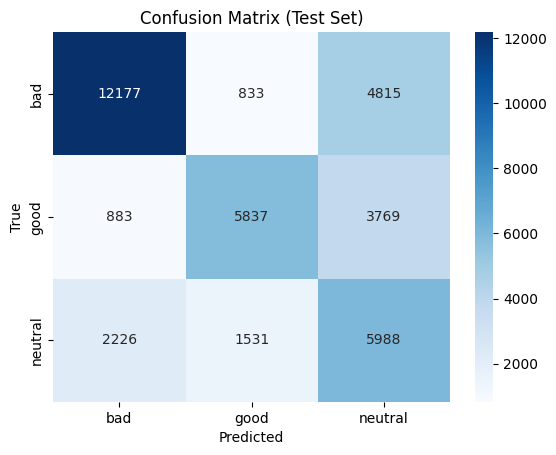

In [ ]:
# lbfgs
X = df['tweets']
y = df['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the tokenized tweets into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply Random OverSampler to balance the classes
rus = RandomOverSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression classifier
pipeline = Pipeline([
    ('maxent', LogisticRegression(max_iter=10,solver='lbfgs'))  # Increased max_iter for convergence in large datasets
])

# Fit the model on the training data
pipeline.fit(X_train_res, y_train_res)

# Predict on the training data for evaluation
y_train_pred = pipeline.predict(X_train_tfidf)

# Predict on the test data
y_test_pred = pipeline.predict(X_test_tfidf)

# Calculate and print train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
print(f'Train F1 Score: {train_f1* 100:.2f}')
print(f'Train Precision: {train_precision* 100:.2f}')
print(f'Train Recall: {train_recall* 100:.2f}')

# Calculate and print classification report for train data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Train Data:\n", train_report)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {test_f1* 100:.2f}')
print(f'Test Precision: {test_precision* 100:.2f}')
print(f'Test Recall: {test_recall* 100:.2f}')

# Calculate and print classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Google Form**

In [ ]:
Form = pd.read_csv("/content/drive/MyDrive/FYP - SA - James & Stephan/DataSet/Form_Responses.csv")
Form.drop(["Timestamp"],axis=1,inplace=True)
Form.columns = ['labels', 'tweets']
Form['labels'] = Form['labels'].replace({
    'Positive': 'good',
    'Negative': 'bad',
    'Neutral' : 'neutral'
})

In [ ]:
Form.head()

,labels,tweets
0,neutral,I m in love with chat gpt 😍#love
1,bad,I believe that chatgpt is diminishing the capa...
2,good,#chatgpt is a helpful tool but still won't #he...
3,good,I utilized ChatGPT to craft this concise messa...
4,good,"Personally i really like it, it's impressive h..."


['red', 'green', 'skyblue']


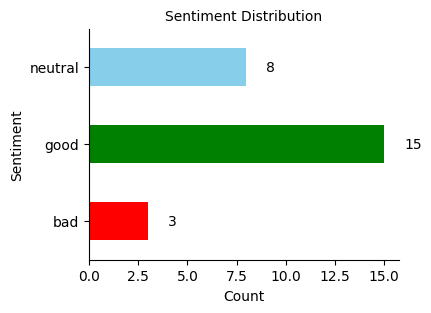

In [ ]:
# Define colors for each sentiment category
colors = [ 'red', 'green','skyblue' ]
print(colors)
# Group by 'labels' and plot the bar graph
ax = Form.groupby('labels').size().plot(kind='barh', color=colors, figsize=(4, 3))

# Add values on top of each bar
for i, v in enumerate(Form.groupby('labels').size()):
    ax.text(v+1, i, str(v), ha='left', va='center', color='black', fontsize=10)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set plot labels and title
plt.xlabel('Count', fontsize=10)
plt.ylabel('Sentiment', fontsize=10)
plt.title('Sentiment Distribution', fontsize=10)

# Show plot
plt.show()

Accuracy on Form Data (Random Forest): 42.31%
Precision on Form Data (Random Forest): 42.72%
Recall on Form Data (Random Forest): 42.31%
F1 Score on Form Data (Random Forest): 40.61%


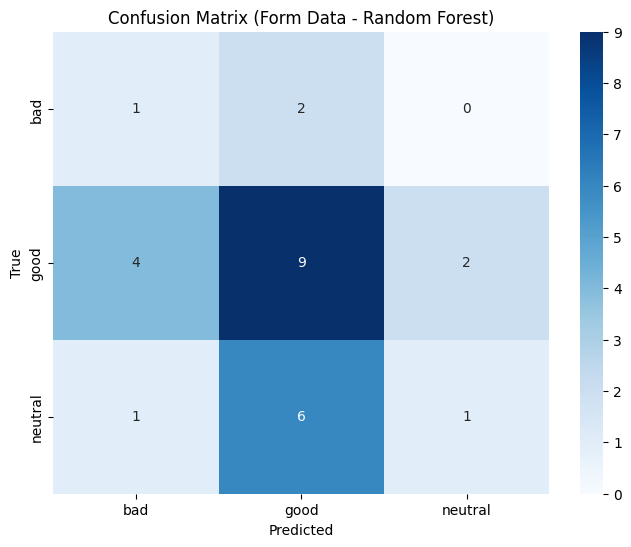

In [ ]:
#Random Forest Model
Form_data_tfidf_rf = vectorizer.transform(Form['tweets'])
Form_pred_rf = RF_Model.predict(Form_data_tfidf_rf)

# Calculate performance metrics
accuracy_form_rf = accuracy_score(Form['labels'], Form_pred_rf)
precision_form_rf = precision_score(Form['labels'], Form_pred_rf, average='weighted')
recall_form_rf = recall_score(Form['labels'], Form_pred_rf, average='weighted')
f1_form_rf = f1_score(Form['labels'], Form_pred_rf, average='weighted')
conf_matrix_form_rf = confusion_matrix(Form['labels'], Form_pred_rf)

# Print performance metrics
print(f'Accuracy on Form Data (Random Forest): {accuracy_form_rf * 100:.2f}%')
print(f'Precision on Form Data (Random Forest): {precision_form_rf * 100:.2f}%')
print(f'Recall on Form Data (Random Forest): {recall_form_rf * 100:.2f}%')
print(f'F1 Score on Form Data (Random Forest): {f1_form_rf * 100:.2f}%')

# Plot confusion matrix for form data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_form_rf, annot=True, fmt='d', cmap='Blues', xticklabels=RF_Model.classes_, yticklabels=RF_Model.classes_)
plt.title('Confusion Matrix (Form Data - Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy on Form Data: 53.85%
Precision on Form Data: 40.28%
Recall on Form Data: 53.85%
F1 Score on Form Data: 45.85%


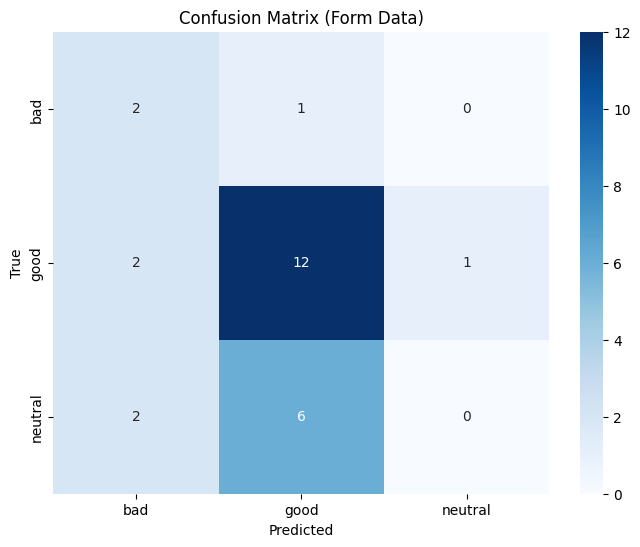

In [ ]:
#MaxEnt Model
Form_data_tfidf = vectorizer.transform(Form['tweets'])

# Predict using MaxEnt model
Form_pred = MaxEnt_Model.predict(Form_data_tfidf)

# Calculate performance metrics
accuracy_form = accuracy_score(Form['labels'], Form_pred)
precision_form = precision_score(Form['labels'], Form_pred, average='weighted')
recall_form = recall_score(Form['labels'], Form_pred, average='weighted')
f1_form = f1_score(Form['labels'], Form_pred, average='weighted')
conf_matrix_form = confusion_matrix(Form['labels'], Form_pred)

# Print performance metrics
print(f'Accuracy on Form Data: {accuracy_form * 100:.2f}%')
print(f'Precision on Form Data: {precision_form * 100:.2f}%')
print(f'Recall on Form Data: {recall_form * 100:.2f}%')
print(f'F1 Score on Form Data: {f1_form * 100:.2f}%')

# Plot confusion matrix for form data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_form, annot=True, fmt='d', cmap='Blues', xticklabels=MaxEnt_Model.classes_, yticklabels=MaxEnt_Model.classes_)
plt.title('Confusion Matrix (Form Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 [==============================] - 0s 69ms/step
Accuracy on Form Data (DNN): 30.77%
Precision on Form Data (DNN): 47.70%
Recall on Form Data (DNN): 30.77%
F1 Score on Form Data (DNN): 34.92%


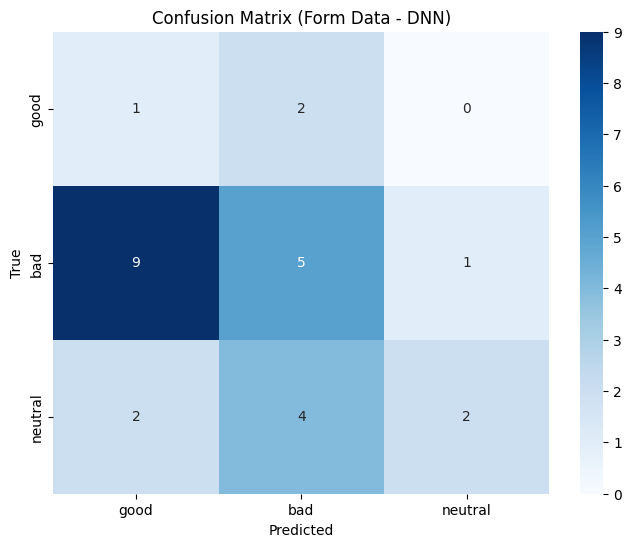

In [ ]:
#DNN Model
from sklearn.preprocessing import LabelEncoder

classes = ['good', 'bad', 'neutral']
# Preprocess the form data
Form_data_seq = tokenizer.texts_to_sequences(Form['tweets'])
Form_data_pad = pad_sequences(Form_data_seq, maxlen=max_len)

# Predict using DNN model
Form_pred_dnn = DNN_Model.predict(Form_data_pad)
Form_pred_dnn_classes = np.argmax(Form_pred_dnn, axis=1)

# Convert labels to numbers using label encoding
label_encoder = LabelEncoder()
Form['labels_encoded'] = label_encoder.fit_transform(Form['labels'])

# Now use 'labels_encoded' column for computing performance metrics
precision_form_dnn = precision_score(Form['labels_encoded'], Form_pred_dnn_classes, average='weighted')

# Calculate performance metrics
accuracy_form_dnn = accuracy_score(Form['labels_encoded'], Form_pred_dnn_classes)
precision_form_dnn = precision_score(Form['labels_encoded'], Form_pred_dnn_classes, average='weighted')
recall_form_dnn = recall_score(Form['labels_encoded'], Form_pred_dnn_classes, average='weighted')
f1_form_dnn = f1_score(Form['labels_encoded'], Form_pred_dnn_classes, average='weighted')
conf_matrix_form_dnn = confusion_matrix(Form['labels_encoded'], Form_pred_dnn_classes)

# Print performance metrics
print(f'Accuracy on Form Data (DNN): {accuracy_form_dnn * 100:.2f}%')
print(f'Precision on Form Data (DNN): {precision_form_dnn * 100:.2f}%')
print(f'Recall on Form Data (DNN): {recall_form_dnn * 100:.2f}%')
print(f'F1 Score on Form Data (DNN): {f1_form_dnn * 100:.2f}%')

# Plot confusion matrix for form data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_form_dnn, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Form Data - DNN)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#**DNN**

Epoch 1/5
2350/2350 [==============================] - 87s 36ms/step - loss: 0.9906 - accuracy: 0.5421 - val_loss: 1.2767 - val_accuracy: 0.1808 - lr: 5.0000e-05
Epoch 2/5
2350/2350 [==============================] - 87s 37ms/step - loss: 0.6572 - accuracy: 0.7298 - val_loss: 0.8558 - val_accuracy: 0.6030 - lr: 5.0000e-05
Epoch 3/5
2350/2350 [==============================] - 126s 54ms/step - loss: 0.4892 - accuracy: 0.8271 - val_loss: 0.7031 - val_accuracy: 0.7504 - lr: 5.0000e-05
Epoch 4/5
2350/2350 [==============================] - 94s 40ms/step - loss: 0.4252 - accuracy: 0.8637 - val_loss: 0.5874 - val_accuracy: 0.8169 - lr: 5.0000e-05
Epoch 5/5
5873/5873 [==============================] - 29s 5ms/step - loss: 0.3707 - accuracy: 0.8908
Train Accuracy: 89.08%
5873/5873 [==============================] - 28s 5ms/step
Classification Report for Train Data:
               precision    recall  f1-score   support

        Good       0.91      0.92      0.91     62641
         Bad       0

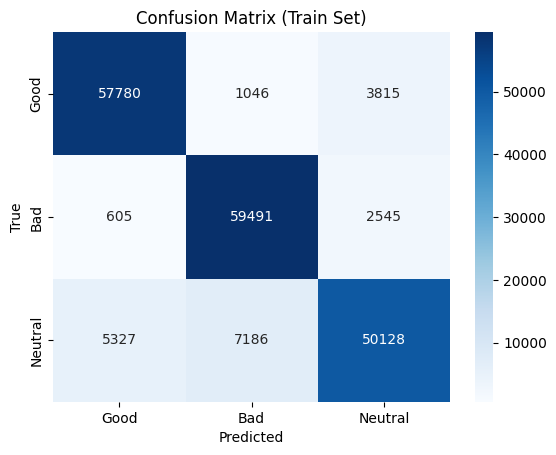

1784/1784 [==============================] - 9s 5ms/step - loss: 0.4137 - accuracy: 0.8638
Test Accuracy: 86.38%
1784/1784 [==============================] - 7s 4ms/step
Classification Report for Test Data:
               precision    recall  f1-score   support

        Good       0.87      0.88      0.87     15687
         Bad       0.90      0.93      0.92     26841
     Neutral       0.78      0.72      0.75     14560

    accuracy                           0.86     57088
   macro avg       0.85      0.84      0.85     57088
weighted avg       0.86      0.86      0.86     57088

Test F1 Score: 86.23
Test Precision: 86.16
Test Recall: 86.38
Confusion Matrix (Test Set):
 [[13764   412  1511]
 [  335 25006  1500]
 [ 1754  2266 10540]]


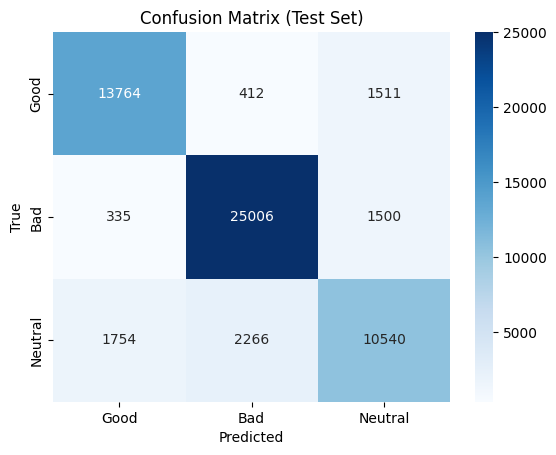

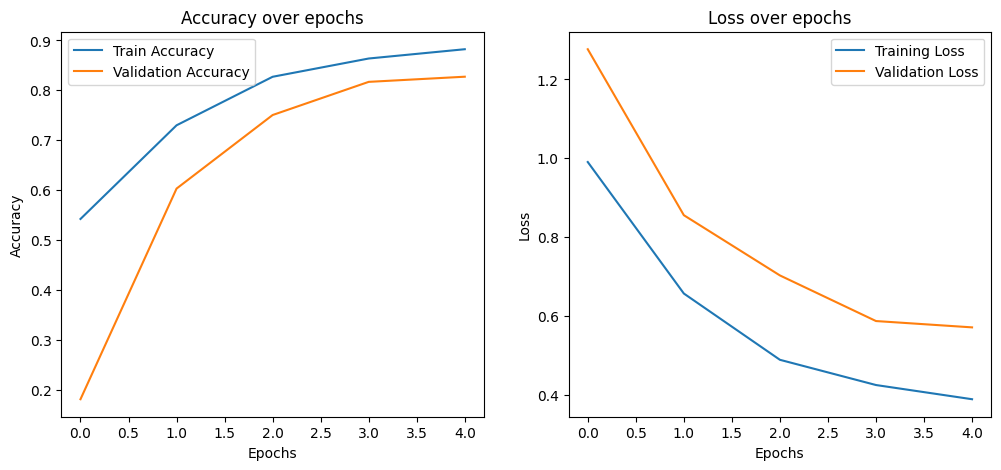

In [ ]:
# lr=0.00005 32
# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Evaluate the model on the test data
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt=' d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##tests

Epoch 1/5
1903/1903 [==============================] - 55s 28ms/step - loss: 1.0004 - accuracy: 0.5195 - val_loss: 0.9339 - val_accuracy: 0.5685 - lr: 5.0000e-05
Epoch 2/5
1903/1903 [==============================] - 47s 25ms/step - loss: 0.7711 - accuracy: 0.6632 - val_loss: 0.5933 - val_accuracy: 0.7594 - lr: 5.0000e-05
Epoch 3/5
1903/1903 [==============================] - 47s 25ms/step - loss: 0.5640 - accuracy: 0.7829 - val_loss: 0.5025 - val_accuracy: 0.8190 - lr: 5.0000e-05
Epoch 4/5
1903/1903 [==============================] - 72s 38ms/step - loss: 0.4890 - accuracy: 0.8291 - val_loss: 0.4681 - val_accuracy: 0.8367 - lr: 5.0000e-05
Epoch 5/5
4758/4758 [==============================] - 18s 4ms/step - loss: 0.3912 - accuracy: 0.8731
Train Accuracy: 87.31%
4758/4758 [==============================] - 18s 4ms/step
Train F1 Score: 87.16
Train Precision: 87.10
Train Recall: 87.31
Classification Report for Train Data:
               precision    recall  f1-score   support

         b

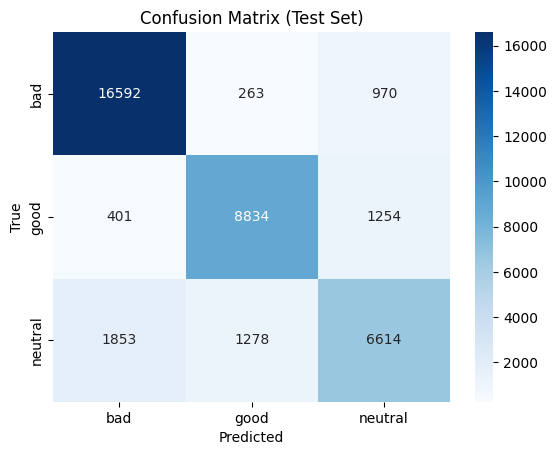

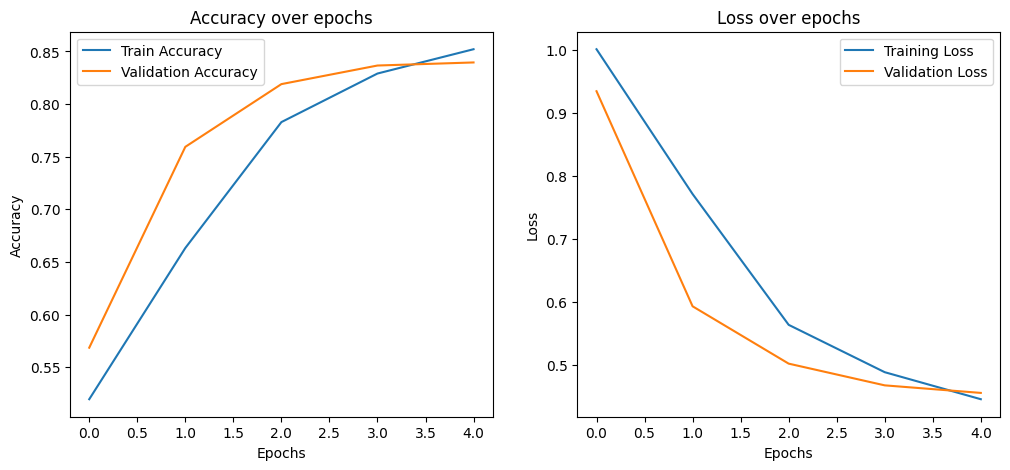

In [ ]:
# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Evaluate the model on the test data
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/5
3806/3806 [==============================] - 137s 35ms/step - loss: 0.9872 - accuracy: 0.5309 - val_loss: 0.8476 - val_accuracy: 0.6172 - lr: 5.0000e-05
Epoch 2/5
3806/3806 [==============================] - 104s 27ms/step - loss: 0.6791 - accuracy: 0.7170 - val_loss: 0.5331 - val_accuracy: 0.7995 - lr: 5.0000e-05
Epoch 3/5
3806/3806 [==============================] - 87s 23ms/step - loss: 0.5130 - accuracy: 0.8158 - val_loss: 0.4705 - val_accuracy: 0.8313 - lr: 5.0000e-05
Epoch 4/5
3806/3806 [==============================] - 94s 25ms/step - loss: 0.4497 - accuracy: 0.8502 - val_loss: 0.4462 - val_accuracy: 0.8453 - lr: 5.0000e-05
Epoch 5/5
4758/4758 [==============================] - 19s 4ms/step - loss: 0.3542 - accuracy: 0.8896
Train Accuracy: 88.96%
4758/4758 [==============================] - 15s 3ms/step
Train F1 Score: 88.93
Train Precision: 88.90
Train Recall: 88.96
Classification Report for Train Data:
               precision    recall  f1-score   support

        

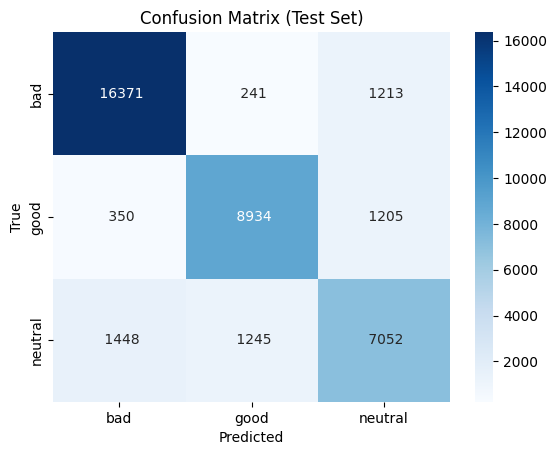

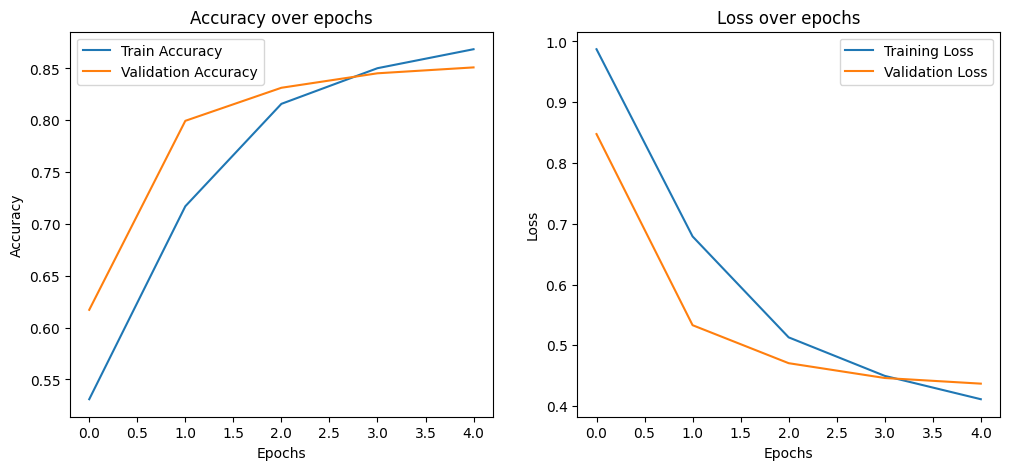

In [ ]:
# lr=0.00005 32
# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Evaluate the model on the test data
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt=' d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10
3806/3806 [==============================] - 85s 22ms/step - loss: 0.9636 - accuracy: 0.5450 - val_loss: 0.7596 - val_accuracy: 0.6577 - lr: 5.0000e-05
Epoch 2/10
3806/3806 [==============================] - 84s 22ms/step - loss: 0.6386 - accuracy: 0.7396 - val_loss: 0.5215 - val_accuracy: 0.8066 - lr: 5.0000e-05
Epoch 3/10
3806/3806 [==============================] - 84s 22ms/step - loss: 0.5009 - accuracy: 0.8238 - val_loss: 0.4661 - val_accuracy: 0.8365 - lr: 5.0000e-05
Epoch 4/10
3806/3806 [==============================] - 80s 21ms/step - loss: 0.4459 - accuracy: 0.8524 - val_loss: 0.4434 - val_accuracy: 0.8465 - lr: 5.0000e-05
Epoch 5/10
3806/3806 [==============================] - 81s 21ms/step - loss: 0.4112 - accuracy: 0.8686 - val_loss: 0.4354 - val_accuracy: 0.8508 - lr: 5.0000e-05
Epoch 6/10
3806/3806 [==============================] - 90s 24ms/step - loss: 0.3811 - accuracy: 0.8808 - val_loss: 0.4408 - val_accuracy: 0.8486 - lr: 5.0000e-05
Epoch 7/10
3806/3806 [

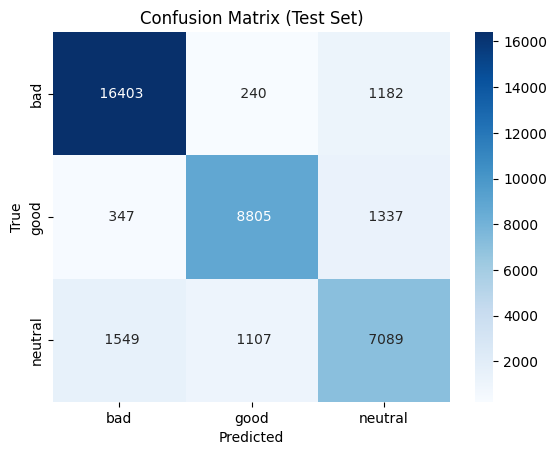

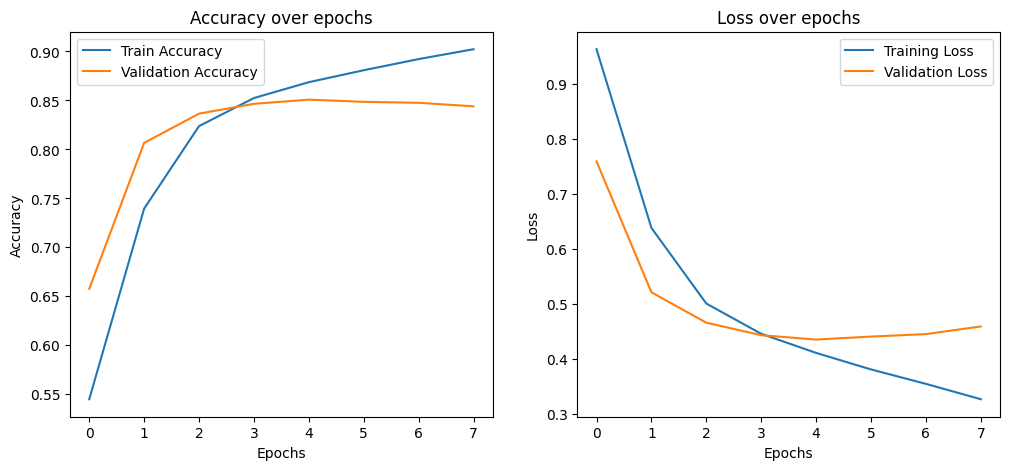

In [ ]:
# lr=0.00005 32 ep=10
# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Evaluate the model on the test data
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt=' d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10
1903/1903 [==============================] - 48s 25ms/step - loss: 1.0030 - accuracy: 0.5172 - val_loss: 0.9406 - val_accuracy: 0.5647 - lr: 5.0000e-05
Epoch 2/10
1903/1903 [==============================] - 48s 25ms/step - loss: 0.7876 - accuracy: 0.6560 - val_loss: 0.6120 - val_accuracy: 0.7424 - lr: 5.0000e-05
Epoch 3/10
1903/1903 [==============================] - 47s 25ms/step - loss: 0.5739 - accuracy: 0.7771 - val_loss: 0.5064 - val_accuracy: 0.8149 - lr: 5.0000e-05
Epoch 4/10
1903/1903 [==============================] - 46s 24ms/step - loss: 0.4927 - accuracy: 0.8276 - val_loss: 0.4673 - val_accuracy: 0.8382 - lr: 5.0000e-05
Epoch 5/10
1903/1903 [==============================] - 46s 24ms/step - loss: 0.4491 - accuracy: 0.8522 - val_loss: 0.4510 - val_accuracy: 0.8450 - lr: 5.0000e-05
Epoch 6/10
1903/1903 [==============================] - 48s 25ms/step - loss: 0.4179 - accuracy: 0.8675 - val_loss: 0.4420 - val_accuracy: 0.8500 - lr: 5.0000e-05
Epoch 7/10
1903/1903 [

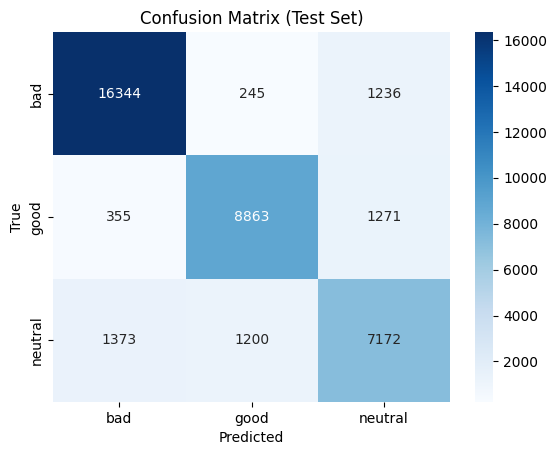

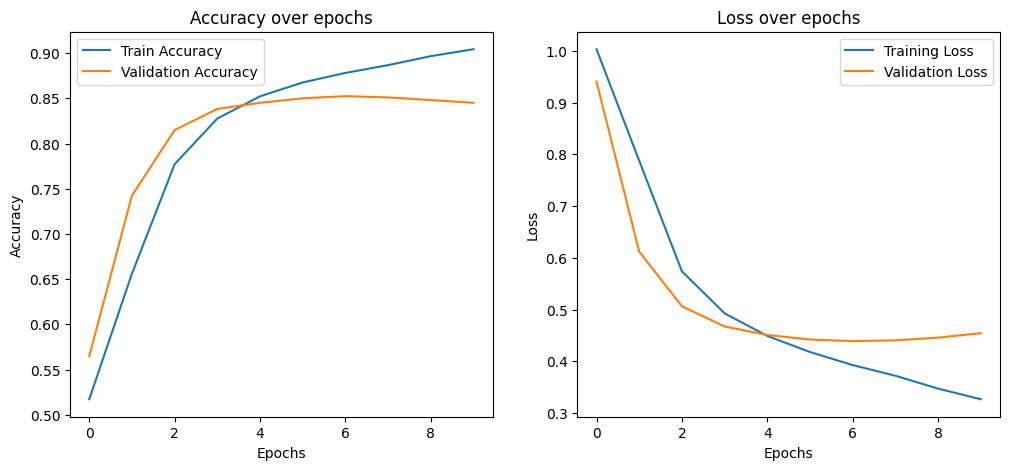

In [ ]:
# lr=0.00005 64 ep=10
# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Evaluate the model on the test data
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/5
1903/1903 [==============================] - 45s 23ms/step - loss: 0.9035 - accuracy: 0.5820 - val_loss: 0.6087 - val_accuracy: 0.7541 - lr: 1.0000e-04
Epoch 2/5
1903/1903 [==============================] - 44s 23ms/step - loss: 0.5468 - accuracy: 0.7949 - val_loss: 0.4678 - val_accuracy: 0.8360 - lr: 1.0000e-04
Epoch 3/5
1903/1903 [==============================] - 46s 24ms/step - loss: 0.4519 - accuracy: 0.8500 - val_loss: 0.4394 - val_accuracy: 0.8494 - lr: 1.0000e-04
Epoch 4/5
1903/1903 [==============================] - 46s 24ms/step - loss: 0.4046 - accuracy: 0.8715 - val_loss: 0.4376 - val_accuracy: 0.8487 - lr: 1.0000e-04
Epoch 5/5
4758/4758 [==============================] - 18s 4ms/step - loss: 0.3140 - accuracy: 0.9043
Train Accuracy: 90.43%
4758/4758 [==============================] - 16s 3ms/step
Train F1 Score: 90.42
Train Precision: 90.42
Train Recall: 90.43
Classification Report for Train Data:
               precision    recall  f1-score   support

         b

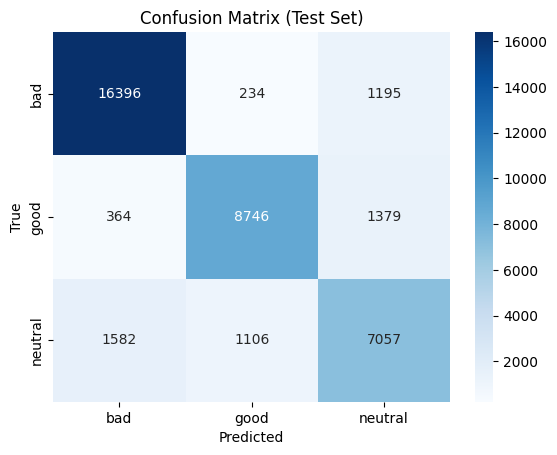

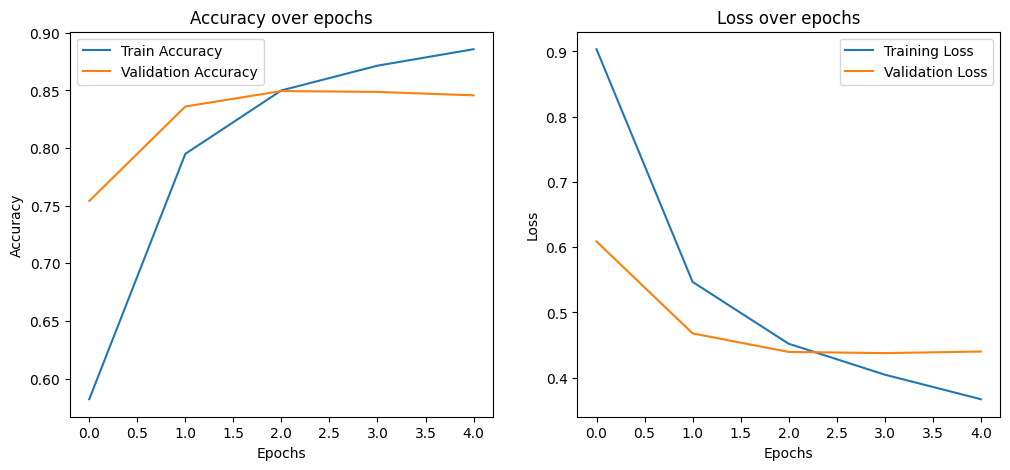

In [ ]:
#lr=0.0001 64
# Parameters
max_words = 10000
max_len = 20
embedding_dim = 100

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
DNN_Model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.0001)
DNN_Model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = DNN_Model.fit(X_train_pad, y_train_categorical, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the training data
train_loss, DNN_train_accuracy = DNN_Model.evaluate(X_train_pad, y_train_categorical)
print(f'Train Accuracy: {DNN_train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = DNN_Model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_categorical, axis=1)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1 * 100:.2f}')
print(f'Train Precision: {train_precision * 100:.2f}')
print(f'Train Recall: {train_recall * 100:.2f}')

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Train Data:\n", train_report)

# Evaluate the model on the test data
loss, DNN_test_accuracy = DNN_Model.evaluate(X_test_pad, y_test_categorical)
print(f'Test Accuracy: {DNN_test_accuracy * 100:.2f}%')

# Make predictions on test data
predictions = DNN_Model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(y_test_encoded, predicted_classes, average='weighted')
test_precision = precision_score(y_test_encoded, predicted_classes, average='weighted')
test_recall = recall_score(y_test_encoded, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1 * 100:.2f}')
print(f'Test Precision: {test_precision * 100:.2f}')
print(f'Test Recall: {test_recall * 100:.2f}')

# Compute detailed classification report for test data
test_report = classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_)
print("Classification Report for Test Data:\n", test_report)

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test_encoded, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/5
2350/2350 [==============================] - 129s 54ms/step - loss: 0.9517 - accuracy: 0.5681 - val_loss: 1.1538 - val_accuracy: 0.2136 - lr: 5.0000e-05
Epoch 2/5
2350/2350 [==============================] - 125s 53ms/step - loss: 0.5963 - accuracy: 0.7591 - val_loss: 0.8555 - val_accuracy: 0.6259 - lr: 5.0000e-05
Epoch 3/5
2350/2350 [==============================] - 123s 52ms/step - loss: 0.4636 - accuracy: 0.8415 - val_loss: 0.6838 - val_accuracy: 0.7610 - lr: 5.0000e-05
Epoch 4/5
2350/2350 [==============================] - 121s 52ms/step - loss: 0.4055 - accuracy: 0.8735 - val_loss: 0.5729 - val_accuracy: 0.8240 - lr: 5.0000e-05
Epoch 5/5
5873/5873 [==============================] - 27s 5ms/step - loss: 0.3431 - accuracy: 0.9004
Train Accuracy: 90.04%
5873/5873 [==============================] - 28s 5ms/step
Classification Report for Train Data:
               precision    recall  f1-score   support

        Good       0.89      0.95      0.92     62641
         Bad     

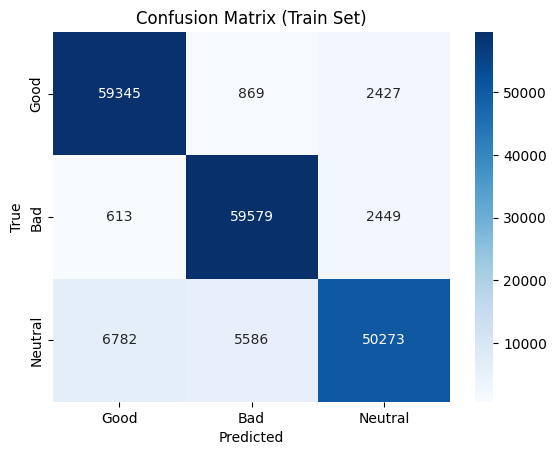

1784/1784 [==============================] - 10s 5ms/step - loss: 0.4248 - accuracy: 0.8594
Test Accuracy: 85.94%
1784/1784 [==============================] - 7s 4ms/step
Classification Report for Test Data:
               precision    recall  f1-score   support

        Good       0.84      0.90      0.87     15687
         Bad       0.91      0.92      0.92     26841
     Neutral       0.78      0.70      0.74     14560

    accuracy                           0.86     57088
   macro avg       0.84      0.84      0.84     57088
weighted avg       0.86      0.86      0.86     57088

Test F1 Score: 85.74
Test Precision: 85.74
Test Recall: 85.94
Confusion Matrix (Test Set):
 [[14130   392  1165]
 [  396 24794  1651]
 [ 2377  2045 10138]]


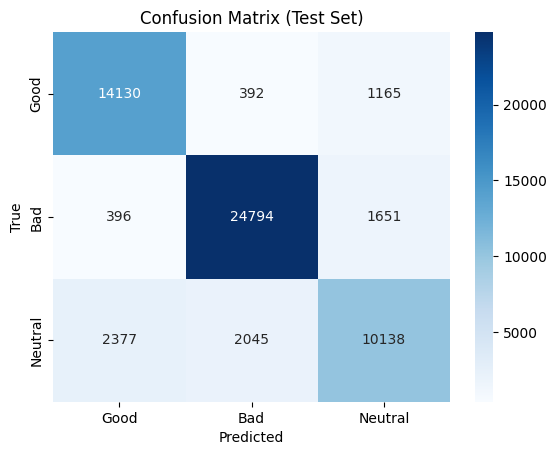

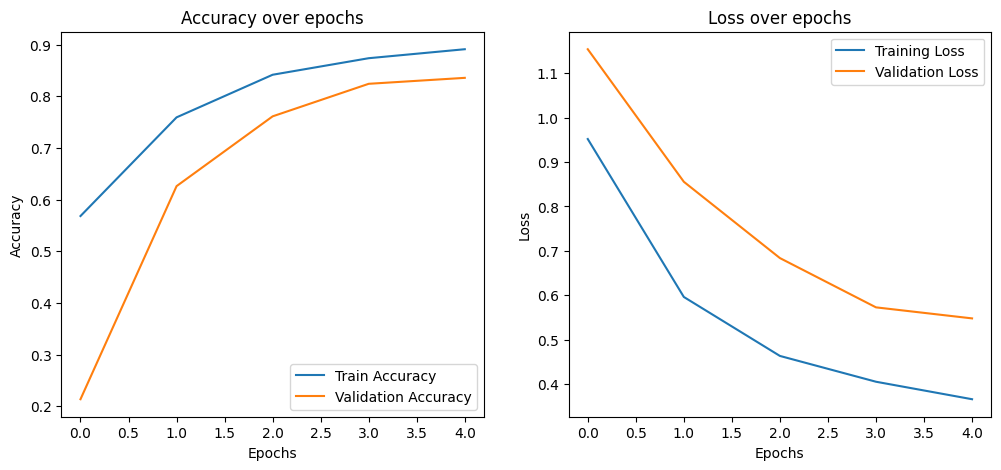

In [ ]:
# 200 embedding dimensions

# Parameters
max_words = 10000  # Maximum number of words to be used (most frequent)
embedding_dim = 200  # Embedding dimensions for each word
max_len = 50

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Assuming df is your DataFrame containing the tweets and labels
X = df['tweets']
y = df['labels']

# Encode labels to integers
y_encoded = pd.factorize(y)[0]
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)

# Apply Random OverSampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)

# Flatten resampled data
X_train_resampled = X_train_resampled.flatten()

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_resampled)
X_train_seq = tokenizer.texts_to_sequences(X_train_resampled)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build and compile the DNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjusted for 3 classes
])

# Decrease learning rate
adam_optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train_resampled, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train_pad, y_train_resampled)
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Make predictions on training data for evaluation
train_predictions = model.predict(X_train_pad)
train_predicted_classes = np.argmax(train_predictions, axis=1)
train_original_classes = np.argmax(y_train_resampled, axis=1)

# Compute detailed classification report for training data
train_report = classification_report(train_original_classes, train_predicted_classes, target_names=['Good', 'Bad', 'Neutral'])
print("Classification Report for Train Data:\n", train_report)

# Calculate and print train F1 score, precision, and recall
train_f1 = f1_score(train_original_classes, train_predicted_classes, average='weighted')
train_precision = precision_score(train_original_classes, train_predicted_classes, average='weighted')
train_recall = recall_score(train_original_classes, train_predicted_classes, average='weighted')
print(f'Train F1 Score: {train_f1* 100:.2f}')
print(f'Train Precision: {train_precision* 100:.2f}')
print(f'Train Recall: {train_recall* 100:.2f}')

# Confusion matrix for the training set
conf_matrix_train = confusion_matrix(train_original_classes, train_predicted_classes)
print("Confusion Matrix (Train Set):\n", conf_matrix_train)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad', 'Neutral'], yticklabels=['Good', 'Bad', 'Neutral'])
plt.title('Confusion Matrix (Train Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Make predictions on test data
predictions = model.predict(X_test_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Decode predictions back to labels
original_classes = np.argmax(y_test, axis=1)

# Compute detailed classification report for test data
test_report = classification_report(original_classes, predicted_classes, target_names=['Good', 'Bad', 'Neutral'])
print("Classification Report for Test Data:\n", test_report)

# Calculate and print test F1 score, precision, and recall
test_f1 = f1_score(original_classes, predicted_classes, average='weighted')
test_precision = precision_score(original_classes, predicted_classes, average='weighted')
test_recall = recall_score(original_classes, predicted_classes, average='weighted')
print(f'Test F1 Score: {test_f1* 100:.2f}')
print(f'Test Precision: {test_precision* 100:.2f}')
print(f'Test Recall: {test_recall* 100:.2f}')

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(original_classes, predicted_classes)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad', 'Neutral'], yticklabels=['Good', 'Bad', 'Neutral'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Hugging Face Text Classification**

In [ ]:
#LLM used for the project

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

good_tweets = resample(df[df['labels'] == 'good'], n_samples=10000, random_state=42)
bad_tweets = resample(df[df['labels'] == 'bad'], n_samples=10000, random_state=42)
neutral_tweets = resample(df[df['labels'] == 'neutral'], n_samples=10000, random_state=42)

# Concatenate the sampled tweets
sampled_df = pd.concat([good_tweets, bad_tweets, neutral_tweets])

# Shuffle the dataframe
sampled_df = sampled_df.sample(frac=1, random_state=42)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(sampled_df["tweets"], sampled_df['labels'], test_size=0.2, random_state=42)

texts = Xh_test.tolist()
true_labels = ['negative' if label == 'bad' else 'positive' if label == 'good' else label for label in yh_test]

predictions = sentiment_task(texts)
predicted_labels = [pred['label'] for pred in predictions]
# Evaluate the modelT
TC_accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {TC_accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluation Metrics:
Accuracy: 44.87
Precision: 47.88
Recall: 44.87
F1 Score: 44.33
Classification Report:
               precision    recall  f1-score   support

    negative       0.48      0.26      0.33      2023
     neutral       0.35      0.57      0.44      1968
    positive       0.60      0.52      0.56      2009

    accuracy                           0.45      6000
   macro avg       0.48      0.45      0.44      6000
weighted avg       0.48      0.45      0.44      6000



In [ ]:
#6000 records

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

good_tweets = resample(df[df['labels'] == 'good'], n_samples=2000, random_state=42)
bad_tweets = resample(df[df['labels'] == 'bad'], n_samples=2000, random_state=42)
neutral_tweets = resample(df[df['labels'] == 'neutral'], n_samples=2000, random_state=42)

# Concatenate the sampled tweets
sampled_df = pd.concat([good_tweets, bad_tweets, neutral_tweets])

# Shuffle the dataframe
sampled_df = sampled_df.sample(frac=1, random_state=42)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(sampled_df["tweets"], sampled_df['labels'], test_size=0.2, random_state=42)

texts = Xh_test.tolist()
true_labels = ['negative' if label == 'bad' else 'positive' if label == 'good' else label for label in yh_test]

predictions = sentiment_task(texts)
predicted_labels = [pred['label'] for pred in predictions]
# Evaluate the model
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Evaluation Metrics:
Accuracy: 45.17
Precision: 48.35
Recall: 45.17
F1 Score: 44.88
Classification Report:
               precision    recall  f1-score   support

    negative       0.47      0.27      0.34       390
     neutral       0.36      0.57      0.44       393
    positive       0.62      0.51      0.56       417

    accuracy                           0.45      1200
   macro avg       0.48      0.45      0.45      1200
weighted avg       0.48      0.45      0.45      1200



### tuned

In [ ]:
#Tuned but didnt work
# Load the model and tokenizer
# sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)
Xh_train, Xh_test, yh_train, yh_test = train_test_split(df["tweets"], df['labels'], test_size=0.99, random_state=42)

texts = Xh_test.tolist()
label_map = {'bad': 0, 'neutral': 1, 'good': 2}
yh_train = yh_train.map(label_map)
yh_test = yh_test.map(label_map)
train_df = pd.DataFrame({'text': Xh_train, 'label': yh_train})
test_df = pd.DataFrame({'text': Xh_test, 'label': yh_test})
# true_labels = yh_test.tolist()
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True,max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

# Setting the format to PyTorch tensors
train_dataset.set_format("torch")
test_dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)  # Assuming binary classification

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
trainer.train()

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Map numerical labels back to string labels for evaluation
reverse_label_map = {0: 'bad', 1: 'neutral', 2: 'good'}
predicted_labels = [reverse_label_map[pred] for pred in preds]
true_labels = [reverse_label_map[label] for label in yh_test]

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/214827 [00:00<?, ? examples/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
print(f"accelerate version: {accelerate.__version__}")
print(f"transformers version: {transformers.__version__}")

accelerate version: 0.30.1
transformers version: 4.41.1


In [ ]:
# # # sentiment
# start_time = time.time()

# predictions = sentiment_task(["I believe that chatgpt is diminishing the capability of a person to use his brain. Instead of thinking how to write a mail we ask chatgpt, and how to write a code we ask chatgpt. It's the easy way and it's not giving us the ability to think for ourselves and develop our brain.","#chatgpt is a helpful tool but still won't #help in some cases. Anyways it is so #important in our lives"])
# predicted_labels = [pred['label'].lower() for pred in predictions]
# true_labels = ["Negative","Positive"]
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy}")
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Time taken for RandomizedSearchCV: {elapsed_time / 60:.2f} minutes")


# **Hugging Face Zero shot classification**

In [ ]:
#balanced sampled data
classifier = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")

# Sample 1000 tweets from each class (good, bad, neutral)
good_tweets = resample(df[df['labels'] == 'good'], n_samples=2000, random_state=42)
bad_tweets = resample(df[df['labels'] == 'bad'], n_samples=2000, random_state=42)
neutral_tweets = resample(df[df['labels'] == 'neutral'], n_samples=2000, random_state=42)

# Concatenate the sampled tweets
sampled_df = pd.concat([good_tweets, bad_tweets, neutral_tweets])

# Shuffle the dataframe
sampled_df = sampled_df.sample(frac=1, random_state=42)

candidate_labels = ['good', 'bad', 'neutral']

def classify_and_extract_label(text):
    result = classifier(text, candidate_labels, max_length=512, truncation=True)
    return result['labels'][0]

# Apply the classifier to each tweet
sampled_df['predicted_labels'] = sampled_df['tweets'].apply(classify_and_extract_label)

# Ensure all labels and predictions are strings
sampled_df['labels'] = sampled_df['labels'].astype(str)
sampled_df['predicted_labels'] = sampled_df['predicted_labels'].astype(str)

# Get the ground truth labels and predicted labels
y_true = sampled_df['labels']
y_pred = sampled_df['predicted_labels']

# Evaluate the model
ZC_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {ZC_accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_true, y_pred))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Metrics:
Accuracy: 41.03
Precision: 43.13
Recall: 41.03
F1 Score: 37.41
Classification Report:
               precision    recall  f1-score   support

         bad       0.52      0.30      0.38      2000
        good       0.38      0.77      0.51      2000
     neutral       0.40      0.17      0.23      2000

    accuracy                           0.41      6000
   macro avg       0.43      0.41      0.37      6000
weighted avg       0.43      0.41      0.37      6000



In [ ]:
#imbalanced
classifier = pipeline("zero-shot-classification",model="sileod/deberta-v3-base-tasksource-nli")

candidate_labels = ['good', 'bad', 'neutral']

def classify_and_extract_label(text):
    result = classifier(text, candidate_labels, max_length=512, truncation=True)
    return result['labels'][0]  # Get the label with the highest score

# Apply the classifier to each tweet
df['predicted_labels'] = df['tweets'].apply(classify_and_extract_label)

# Ensure all labels and predictions are strings
df['labels'] = df['labels'].astype(str)
df['predicted_labels'] = df['predicted_labels'].astype(str)

# Get the ground truth labels and predicted labels
y_true = df['labels']
y_pred = df['predicted_labels']

# Evaluate the model
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy* 100:.2f}")
print(f"Precision: {precision* 100:.2f}")
print(f"Recall: {recall* 100:.2f}")
print(f"F1 Score: {f1* 100:.2f}")
print("Classification Report:\n", classification_report(y_true, y_pred))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Metrics:
Accuracy: 0.0207
Precision: 0.4716
Recall: 0.0207
F1 Score: 0.0382


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

         bad       0.65      0.01      0.03     89482
        good       0.34      0.04      0.08     52184
         nan       0.00      0.00      0.00         0
     neutral       0.28      0.01      0.01     48627

    accuracy                           0.02    190293
   macro avg       0.32      0.02      0.03    190293
weighted avg       0.47      0.02      0.04    190293



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
